In [ ]:
# Import libraries
import sys
import geopandas as gpd
import pandas as pd
from shapely import force_2d
from pathlib import Path
from scipy.stats import pearsonr, spearmanr
import numpy as np
from shapely.geometry import shape
import unicodedata
from shapely.ops import unary_union
from shapely.geometry import mapping
from core.gee_client import init_gee
import ee
from sklearn.metrics import mean_absolute_error

# 1. Introduction

# Exploratory Data Analysis (EDA): Validating GEE-Derived Farm Environmental Variables

## Purpose

The purpose of this EDA is to **evaluate whether environmental variables extracted from Google Earth Engine (GEE)** can reliably substitute or complement the farm profile data provided by Product Owner for downstream modelling and decision-making.

Specifically, we assess how well different **GEE datasets and extraction methods** reproduce PO-provided values for the following five environmental variables:

* **Rainfall**
* **Temperature**
* **Soil pH**
* **Elevation**
* **Area**

These variables represent a mix of dynamic climate signals and static terrain characteristics and form the core feature set used for automated farm profiling and suitability modelling.

This analysis supports a key project decision:
**which GEE datasets and spatial aggregation methods are suitable for automated farm profile generation**, especially in regions where field observations are limited or unavailable.

---

## Methodology Overview

We conduct the analysis in **two controlled experiments**, comparing GEE-derived values against PO data at the farm level using consistent farm identifiers.

### Data Quality Assurance

**Prior to all metric computations**, data quality filtering is applied to remove invalid measurements:

* **Invalid pH values removed**: pH = 0 (measurement errors), pH < 3.5 or pH > 10 (physically implausible)
* **Purpose**: Ensure accurate metric computation by excluding data entry errors and sensor malfunctions
* **Impact**: Typically removes 2-3 farms (~0.3%) with invalid measurements
* **Rationale**: Invalid values artificially distort correlation and error metrics, masking true dataset performance

This filtering is applied **consistently across both experiments** to ensure fair comparison.

---

### Experiment 1 — Centroid Extraction

* Each farm polygon is reduced to its **centroid point**
* Environmental variables are extracted at that point
* Datasets tested:
  * **Temperature:** ERA5-Land (2 m air temperature), MODIS Land Surface Temperature
  * **Rainfall:** CHIRPS, ERA5-Land
  * **Soil pH:** OpenLandMap (0–5 cm depth)
  * **Elevation:** SRTM Digital Elevation Model
* **Purpose**: Establish a **baseline** and test a low-cost extraction strategy
* **Metrics computed**: Using cleaned data (invalid measurements removed)

### Experiment 2 — Polygon Aggregation

* Environmental variables are aggregated over the **entire farm polygon**
* Mean values are computed using `reduceRegions`
* The same datasets and data quality filters as Experiment 1 are applied
* **Purpose**: Assess whether spatial averaging improves alignment with PO data
* **Hypothesis tested**: Polygon aggregation should reduce noise from sub-farm heterogeneity

---

## Evaluation Metrics

For each variable–dataset–method combination, we compute:

* **Pearson correlation (r)** — linear agreement between GEE and PO values
* **Spearman correlation (ρ)** — rank/pattern agreement (robust to outliers)
* **Mean Absolute Error (MAE)** — absolute deviation from PO values (same units as variable)

**Interpretation framework:**

| Correlation (r) | Interpretation | Operational Suitability |
|----------------|----------------|------------------------|
| r ≥ 0.9 | Excellent | Direct substitution possible |
| 0.7 ≤ r < 0.9 | Good | Suitable with minor calibration |
| 0.5 ≤ r < 0.7 | Moderate | Useful for patterns, needs calibration |
| 0.3 ≤ r < 0.5 | Weak | Relative trends only |
| r < 0.3 | Poor | Not suitable without local model |

These metrics allow us to distinguish:

* Datasets suitable for **direct substitution** (r ≥ 0.9, low MAE)
* Datasets useful for **relative pattern analysis only** (moderate r, systematic bias)
* Datasets that are **not reliable** for farm-level profiling (r < 0.3)

---

## Enhanced Analysis Components

### 1. Distribution Analysis

Four-panel visualization for each variable:
* **Histogram comparison** — distribution shapes of GEE vs PO values
* **Box plot comparison** — median, quartiles, and outlier identification
* **Error distribution** — pattern of GEE - PO errors (bias detection)
* **Scatter plot** — direct GEE vs PO comparison with 1:1 reference line

**Value**: Distinguishes correctable systematic biases (e.g., temperature offset) from fundamental inadequacies (e.g., pH range compression).

### 2. Centroid vs Polygon Comparison

Direct comparison of spatial extraction methods to answer:
* Does polygon aggregation improve correlation?
* Does it reduce error (MAE)?
* Is the computational cost justified?

**Finding**: For most variables, including soil pH, centroid and polygon methods produce equivalent results. **Recommendation**: Use centroid extraction for operational deployment (faster, equivalent accuracy).

### 3. Dataset-Specific Assessments

For each variable, we identify:
* **Best-performing dataset** based on correlation and MAE
* **Systematic biases** that can be corrected (e.g., temperature offsets)
* **Fundamental limitations** requiring alternative approaches

---

## Expected Outcome

The outcome of this EDA is a **clear, evidence-based recommendation** of:

* Which GEE datasets to use for each environmental variable
* Which spatial extraction method (centroid vs polygon) is preferred
* Which variables should **not** be derived from GEE without additional calibration
* Where local calibration models are necessary (particularly for soil pH)

This provides a defensible foundation for automated, scalable farm profile generation using Earth observation data.

---

## Reference Datasets Used in the EDA

All environmental variables used in this EDA were sourced from publicly available datasets hosted within the Google Earth Engine (GEE) Data Catalog. The following authoritative references allow independent verification of data provenance, spatial resolution, temporal coverage, and processing methodology.

### ERA5-Land Climate Reanalysis (Temperature and Rainfall)

ERA5-Land is a global land-surface reanalysis product produced by the European Centre for Medium-Range Weather Forecasts (ECMWF). It provides hourly and daily aggregated climate variables, including 2 m air temperature and total precipitation.

* Earth Engine catalog (hourly):
  [https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY)
* Earth Engine catalog (daily aggregates):
  [https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_DAILY_AGGR)
* Copernicus Climate Data Store description:
  [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land)

### MODIS Land Surface Temperature (LST)

MODIS Land Surface Temperature products provide daily global estimates of land surface thermal emission derived from the Terra and Aqua satellites.

* MODIS datasets in the Earth Engine catalog:
  [https://developers.google.com/earth-engine/datasets/catalog/modis](https://developers.google.com/earth-engine/datasets/catalog/modis)

### CHIRPS Rainfall

The Climate Hazards Group InfraRed Precipitation with Stations (CHIRPS) dataset is a quasi-global rainfall product spanning 1981 to present, combining satellite imagery with in-situ station observations.

* Earth Engine precipitation datasets (including CHIRPS):
  [https://developers.google.com/earth-engine/datasets/tags/precipitation](https://developers.google.com/earth-engine/datasets/tags/precipitation)
* CHIRPS project description:
  [https://gee-community-catalog.org/projects/chirps_prelim/](https://gee-community-catalog.org/projects/chirps_prelim/)

### OpenLandMap Soil pH

OpenLandMap provides harmonised global soil property layers derived using machine learning models trained on in-situ soil observations. This EDA used the 0–5 cm depth soil pH in water (H₂O) product.

* Earth Engine catalog entry:
  [https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_PH-H2O_USDA-4C1A2A_M_v02](https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_PH-H2O_USDA-4C1A2A_M_v02)

**Note**: Alternative soil pH datasets (SoilGrids, WISE, iSDAsoil) were investigated but found to be either inaccessible in standard GEE catalog or unsuitable for farm-scale analysis in Timor-Leste.

### SRTM Digital Elevation Model and Derived Slope

Elevation and slope variables were derived from the Shuttle Radar Topography Mission (SRTM) digital elevation model.

* CGIAR SRTM 90 m DEM:
  [https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4](https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4)
* USGS SRTM 30 m DEM:
  [https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003)
* SRTM mission overview:
  [https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission](https://en.wikipedia.org/wiki/Shuttle_Radar_Topography_Mission)

---

## Methodological Contributions

This EDA demonstrates several important principles for Earth observation dataset validation:

1. **Data quality filtering is essential** — Invalid measurements must be removed before computing metrics
2. **Dataset choice matters more than extraction method** — Sophisticated spatial aggregation cannot fix fundamentally poor datasets
3. **Distribution analysis reveals root causes** — Four-panel visualization distinguishes correctable biases from fundamental inadequacies
4. **Field measurements are irreplaceable** — In data-sparse regions, local calibration using ground truth outperforms global products
5. **Transparent limitation documentation** — Clearly stating what doesn't work is as important as documenting successes

This framework can be applied to validate any Earth observation dataset against ground truth measurements in agricultural applications.

# 2. Get Timor Leste Farm's locations and Merge with Farm Sample

#### This work prepares a clean and reliable farm polygon lookup and maps it to the farm sample dataset provided by PO for consistent spatial analysis.

In [37]:
# Read all farm boundaries GeoPackage
GPKG_PATH = "../assets/farm_boundaries.gpkg"
gdf = gpd.read_file(GPKG_PATH)
gdf.drop(columns=["Name"]).head()

,Suco,Aldeia,treeo2_id,plant_year,Subdistrict,layer,geometry
0,Lavateri,Onortibalari,NaN,NaN,None,Baguia_farms_original,"MULTIPOLYGON Z (((126.67605 -8.56847 0, 126.67..."
1,Lavateri,Onortibalari,NaN,NaN,None,Baguia_farms_original,"MULTIPOLYGON Z (((126.68013 -8.56719 0, 126.68..."
2,Alaua-Craik,Neolidae,NaN,NaN,None,Baguia_farms_original,"MULTIPOLYGON Z (((126.66434 -8.64235 0, 126.66..."
3,Alaua-Craik,Neolidae,NaN,NaN,None,Baguia_farms_original,"MULTIPOLYGON Z (((126.65155 -8.63931 0, 126.65..."
4,Alaua-Craik,Neolidae,NaN,NaN,None,Baguia_farms_original,"MULTIPOLYGON Z (((126.66981 -8.64367 0, 126.66..."


In [38]:
# Force geometries to 2D and verify geometry types
gdf["geometry"] = gdf.geometry.apply(force_2d)
gdf.geometry.geom_type.value_counts()

MultiPolygon    3195
Name: count, dtype: int64

In [39]:
# Extract polygon coordinates and prepare farm polygon lookup
gdf["polygon_coords"] = gdf.geometry.apply(lambda g: g.__geo_interface__["coordinates"])

farm_polygons = gdf[["Name", "polygon_coords"]].rename(columns={"Name": "farm_name"})

# farm_polygons.head()

In [40]:
# read farm sample CSV
FARM_SAMPLE_PATH = "../assets/all_farm_sample.csv"
farm_sample = pd.read_csv(FARM_SAMPLE_PATH)
farm_sample = farm_sample.rename(columns={"Name": "farm_name"})
# farm_sample.head()

In [41]:
"""
Improved Farm Matching Strategy - FINAL CORRECTED VERSION
==========================================================

Uses actual column names from your data:
- gdf has column "Name" (not "farm_name")
- farm_sample has column "farm_name"
"""


def normalize_name(s: str) -> str:
    """
    Normalize farm names for safe matching:
    - lowercase
    - strip whitespace
    - remove accents
    - collapse multiple spaces
    """
    if pd.isna(s):
        return s
    s = str(s).lower().strip()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    s = " ".join(s.split())
    return s


# ============================================================================
# STEP 1: Normalize names in both datasets
# ============================================================================

farm_sample = farm_sample.copy()
gdf = gdf.copy()

# IMPORTANT: gdf uses "Name" column, not "farm_name"
farm_sample["_norm_name"] = farm_sample["farm_name"].apply(normalize_name)
gdf["_norm_name"] = gdf["Name"].apply(normalize_name)  # Use "Name" column

print("=" * 70)
print("STEP 1: NAME NORMALIZATION")
print("=" * 70)
print(f"PO farms: {len(farm_sample)}")
print(f"Polygon records (from gdf): {len(gdf)}")
print(f"Unique normalized polygon names: {gdf['_norm_name'].nunique()}")


# ============================================================================
# STEP 2: Merge multiple parcels per farm
# ============================================================================

print("\n" + "=" * 70)
print("STEP 2: MERGING MULTI-PARCEL FARMS")
print("=" * 70)

# Count polygons per farm name
poly_counts = gdf.groupby("_norm_name").size().reset_index(name="parcel_count")

multi_parcel_farms = poly_counts[poly_counts["parcel_count"] > 1]
print(f"Farms with multiple parcels: {len(multi_parcel_farms)}")
print(
    f"Total parcels in multi-parcel farms: {multi_parcel_farms['parcel_count'].sum()}"
)

# Show examples of multi-parcel farms
if len(multi_parcel_farms) > 0:
    print("\nExamples of multi-parcel farms:")
    top_examples = multi_parcel_farms.nlargest(5, "parcel_count")
    for _, row in top_examples.iterrows():
        name = row["_norm_name"]
        count = row["parcel_count"]
        # Get original name (before normalization)
        orig_name = gdf[gdf["_norm_name"] == name]["Name"].iloc[0]
        print(f"  '{orig_name}': {count} parcels")

# Merge multiple parcels into single geometry per farm
gdf_merged = (
    gdf.groupby("_norm_name")
    .agg(
        {
            "geometry": lambda x: unary_union(list(x)),  # Merge all geometries
            "Name": "first",  # Keep original name from "Name" column
        }
    )
    .reset_index()
)

# Convert back to GeoDataFrame
gdf_merged = gpd.GeoDataFrame(gdf_merged, geometry="geometry", crs=gdf.crs)

print(f"\nBefore merging: {len(gdf)} polygon records")
print(f"After merging: {len(gdf_merged)} unique farms")
print(f"Reduction: {len(gdf) - len(gdf_merged)} parcels merged")


# ============================================================================
# STEP 3: Create polygon_coords for merged geometries
# ============================================================================

print("\n" + "=" * 70)
print("STEP 3: PREPARING POLYGON COORDINATES FOR GEE")
print("=" * 70)


def geometry_to_coords(geom):
    """Convert shapely geometry to coordinate list for GEE"""
    if geom is None:
        return None
    return geom.__geo_interface__["coordinates"]


gdf_merged["polygon_coords"] = gdf_merged["geometry"].apply(geometry_to_coords)

print(f"Converted {len(gdf_merged)} geometries to polygon_coords format")


# ============================================================================
# STEP 4: Match PO farms to merged polygons
# ============================================================================

print("\n" + "=" * 70)
print("STEP 4: MATCHING PO FARMS TO POLYGONS")
print("=" * 70)

# Create farm_polygons from merged gdf (matching original structure)
farm_polygons = gdf_merged[["_norm_name", "Name", "polygon_coords", "geometry"]].copy()
farm_polygons = farm_polygons.rename(columns={"Name": "farm_name"})

# Now perform 1-to-1 matching on normalized names
farm_sample_final = farm_sample.merge(
    farm_polygons[["_norm_name", "polygon_coords", "farm_name"]],
    on="_norm_name",
    how="left",
    suffixes=("", "_polygon"),
)

# Split into matched and unmatched
farm_sample_matched = farm_sample_final.dropna(subset=["polygon_coords"]).copy()
farm_sample_unmatched = farm_sample_final[
    farm_sample_final["polygon_coords"].isna()
].copy()

print(f"Total PO farms: {len(farm_sample)}")
print(f"Matched farms: {len(farm_sample_matched)}")
print(f"Unmatched farms: {len(farm_sample_unmatched)}")
print(f"Match rate: {100 * len(farm_sample_matched) / len(farm_sample):.1f}%")


# ============================================================================
# STEP 5: Quality checks and validation
# ============================================================================

print("\n" + "=" * 70)
print("STEP 5: QUALITY CHECKS")
print("=" * 70)

# Check for duplicate matches (should be zero with this approach)
if "farm_id" in farm_sample_matched.columns:
    duplicates = farm_sample_matched[
        farm_sample_matched.duplicated(subset=["farm_id"], keep=False)
    ]
    print(f"Duplicate matches: {len(duplicates)}")
    if len(duplicates) > 0:
        print("WARNING: Some farms matched to multiple polygons!")
else:
    print("No farm_id column to check for duplicates")

# Validate geometry types from merged gdf
geom_types = gdf_merged["geometry"].apply(lambda x: x.geom_type).value_counts()
print("\nGeometry types after merging:")
for geom_type, count in geom_types.items():
    print(f"  {geom_type}: {count}")
    if geom_type == "MultiPolygon":
        print("    (these are farms with non-contiguous parcels)")

# Check if we recovered farms that were previously excluded
print("\nComparison to conservative approach:")
print("  Conservative approach (excludes ambiguous): 911 farms")
print(f"  Improved approach (merges multi-parcel): {len(farm_sample_matched)} farms")
improvement = len(farm_sample_matched) - 911
if improvement > 0:
    print(f"  Additional farms recovered: {improvement}")
else:
    print(
        f"  Difference: {improvement} (check if conservative approach was already using merged data)"
    )

# Verify no missing coords
missing_coords = farm_sample_matched["polygon_coords"].isna().sum()
print(f"\nFarms with valid polygon_coords: {len(farm_sample_matched) - missing_coords}")
if missing_coords > 0:
    print(f"WARNING: {missing_coords} farms have missing polygon_coords!")


print("\n" + "=" * 70)
print("MATCHING COMPLETE")
print("=" * 70)
print(
    f"\nFinal matched dataset: {len(farm_sample_matched)} farms ready for GEE extraction"
)
print("Variable name: farm_sample_matched")
print("Contains merged multi-parcel geometries where applicable")
print("\nTo use in your analysis:")
print("  - Replace 'farm_sample_final' with 'farm_sample_matched'")
print("  - Each farm's polygon_coords now represents merged parcels")


# ============================================================================
# OPTIONAL: Investigate unmatched farms (if reasonable number)
# ============================================================================

if 0 < len(farm_sample_unmatched) <= 20:
    print("\n" + "=" * 70)
    print("INVESTIGATING UNMATCHED FARMS")
    print("=" * 70)

    for name in farm_sample_unmatched["farm_name"].head(10):
        norm = normalize_name(name)
        print(f"  '{name}' (normalized: '{norm}')")
elif len(farm_sample_unmatched) > 20:
    print(f"\n{len(farm_sample_unmatched)} unmatched farms (too many to display)")
    print("Sample of first 5:")
    for name in farm_sample_unmatched["farm_name"].head(5):
        print(f"  '{name}'")

STEP 1: NAME NORMALIZATION
PO farms: 1122
Polygon records (from gdf): 3195
Unique normalized polygon names: 3158

STEP 2: MERGING MULTI-PARCEL FARMS
Farms with multiple parcels: 35
Total parcels in multi-parcel farms: 72

Examples of multi-parcel farms:
  'Francisco da Silva': 3 parcels
  'Pedro Da Costa': 3 parcels
  'Abilio Ximenes': 2 parcels
  'Adriano Dos Santos': 2 parcels
  'Alberto dos Santos': 2 parcels

Before merging: 3195 polygon records
After merging: 3158 unique farms
Reduction: 37 parcels merged

STEP 3: PREPARING POLYGON COORDINATES FOR GEE
Converted 3158 geometries to polygon_coords format

STEP 4: MATCHING PO FARMS TO POLYGONS
Total PO farms: 1122
Matched farms: 940
Unmatched farms: 182
Match rate: 83.8%

STEP 5: QUALITY CHECKS
No farm_id column to check for duplicates

Geometry types after merging:
  Polygon: 3119
  MultiPolygon: 39
    (these are farms with non-contiguous parcels)

Comparison to conservative approach:
  Conservative approach (excludes ambiguous): 91

In [42]:
def coords_to_geometry(coords):
    """
    Convert stored polygon_coords to appropriate Shapely geometry.
    Automatically detects Polygon vs MultiPolygon based on coordinate structure.
    """
    if coords is None:
        return None

    # Detect geometry type by coordinate structure depth
    # Polygon: [[[x, y], [x, y], ...]] - coords[0][0] is a coordinate pair
    # MultiPolygon: [[[[x, y], ...]], [[[x, y], ...]]] - coords[0][0][0] is a coordinate pair

    try:
        # Check if first coordinate is a number (Polygon) or list (MultiPolygon)
        if isinstance(coords[0][0][0], (int, float)):
            # It's a Polygon
            return shape({"type": "Polygon", "coordinates": coords})
        else:
            # It's a MultiPolygon
            return shape({"type": "MultiPolygon", "coordinates": coords})
    except (IndexError, TypeError):
        # Fallback: return None for invalid coords
        return None


farm_sample_final = gpd.GeoDataFrame(
    farm_sample_matched.copy(),
    geometry=farm_sample_matched["polygon_coords"].apply(coords_to_geometry),
    crs="EPSG:4326",
)

print("Geometry types:")
print(farm_sample_final.geom_type.value_counts())
print(f"Total farms with valid geometry: {len(farm_sample_final)}")
print(f"Invalid geometries: {farm_sample_final.geometry.isna().sum()}")

Geometry types:
Polygon         910
MultiPolygon     30
Name: count, dtype: int64
Total farms with valid geometry: 940
Invalid geometries: 0


In [43]:
# Standardise farm identifier column
farm_sample_final = farm_sample_final.rename(columns={"farm_ID": "farm_id"})

# Dissolve parcels into a single geometry per farm
farm_sample_final = farm_sample_final.dissolve(by="farm_id", as_index=False)

print("After dissolve:")
print(farm_sample_final.geom_type.value_counts())
print("Unique farms:", farm_sample_final["farm_id"].nunique())
print("Total rows:", len(farm_sample_final))

After dissolve:
Polygon         910
MultiPolygon     30
Name: count, dtype: int64
Unique farms: 940
Total rows: 940


# 3. Extract Data

In [44]:
GIS_DIR = Path.cwd().parents[0]
if str(GIS_DIR) not in sys.path:
    sys.path.insert(0, str(GIS_DIR))

# Initialise Earth Engine
init_gee()

print("GEE initialised")

GEE initialised


In [45]:
# Robust conversion from GeoPandas geometry to EE geometry


def shapely_to_ee(geom):
    """
    Convert a Shapely Polygon or MultiPolygon to ee.Geometry safely.
    """
    if geom is None:
        raise ValueError("Geometry is None")

    geojson = mapping(geom)

    geom_type = geojson["type"]
    coords = geojson["coordinates"]

    if geom_type == "Polygon":
        return ee.Geometry.Polygon(coords)

    if geom_type == "MultiPolygon":
        return ee.Geometry.MultiPolygon(coords)

    raise ValueError(f"Unsupported geometry type: {geom_type}")

In [46]:
# Build centroid FeatureCollection safely using geodesic logic


def build_farm_centroid_fc(gdf):
    feats = []

    for _, row in gdf.iterrows():
        ee_geom = shapely_to_ee(row.geometry)

        # Geodesic-safe centroid computation
        centroid = ee.Geometry(ee_geom).centroid(maxError=1)

        feat = ee.Feature(
            centroid,
            {
                "farm_id": str(row.farm_id),
                "farm_name": str(row.farm_name),
            },
        )
        feats.append(feat)

    return ee.FeatureCollection(feats)


farms_fc = build_farm_centroid_fc(farm_sample_final)
print("Farm centroid FeatureCollection built:", farms_fc.size().getInfo())

Farm centroid FeatureCollection built: 940


In [47]:
# Build a 5-year (2020–2024) average environmental raster stack from multiple GEE datasets

START_YEAR = 2020
END_YEAR = 2024

# -------------------------------
# Temperature — ERA5-Land (2m air temperature, °C)
# -------------------------------
temp_era5 = (
    ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")
    .select("temperature_2m")
    .filterDate(
        ee.Date.fromYMD(START_YEAR, 1, 1),
        ee.Date.fromYMD(END_YEAR + 1, 1, 1),
    )
    .mean()
    .subtract(273.15)
    .rename("temp_era5")
)

# -------------------------------
# Temperature — MODIS LST (surface temperature, °C)
# -------------------------------
temp_modis = (
    ee.ImageCollection("MODIS/061/MOD11A2")
    .select("LST_Day_1km")
    .filterDate(
        ee.Date.fromYMD(START_YEAR, 1, 1),
        ee.Date.fromYMD(END_YEAR + 1, 1, 1),
    )
    .mean()
    .multiply(0.02)
    .subtract(273.15)
    .rename("temp_modis")
)

# -------------------------------
# Rainfall — CHIRPS (mean annual rainfall, mm)
# -------------------------------
rain_chirps = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .select("precipitation")
    .filterDate(
        ee.Date.fromYMD(START_YEAR, 1, 1),
        ee.Date.fromYMD(END_YEAR + 1, 1, 1),
    )
    .sum()
    .divide(END_YEAR - START_YEAR + 1)
    .rename("rain_chirps")
)

# -------------------------------
# Rainfall — ERA5-Land (mean annual rainfall, mm)
# -------------------------------
rain_era5 = (
    ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")
    .select("total_precipitation_sum")
    .filterDate(
        ee.Date.fromYMD(START_YEAR, 1, 1),
        ee.Date.fromYMD(END_YEAR + 1, 1, 1),
    )
    .sum()
    .multiply(1000)  # meters → mm
    .divide(END_YEAR - START_YEAR + 1)
    .rename("rain_era5")
)

# -------------------------------
# Soil pH — OpenLandMap (0–5 cm)
# -------------------------------
ph_openlandmap = (
    ee.Image("OpenLandMap/SOL/SOL_PH-H2O_USDA-4C1A2A_M/v02")
    .select("b0")
    .divide(10)
    .rename("ph_openlandmap")
)

# -------------------------------
# Elevation — SRTM (m)
# -------------------------------
elevation_srtm = (
    ee.Image("USGS/SRTMGL1_003").select("elevation").rename("elevation_srtm")
)


# -------------------------------
# Stack all datasets
# -------------------------------
stacked_img = (
    temp_era5.addBands(temp_modis)
    .addBands(rain_chirps)
    .addBands(rain_era5)
    .addBands(ph_openlandmap)
    .addBands(elevation_srtm)
)

print(stacked_img.bandNames().getInfo())

['temp_era5', 'temp_modis', 'rain_chirps', 'rain_era5', 'ph_openlandmap', 'elevation_srtm']


In [48]:
# ---------------------------------------------------
# Extract 5-feature values at farm centroids
# ---------------------------------------------------


def extract_at_centroids(image, fc, scale=100):
    return image.reduceRegions(collection=fc, reducer=ee.Reducer.mean(), scale=scale)


centroid_results = extract_at_centroids(stacked_img, farms_fc)

centroid_dicts = centroid_results.getInfo()["features"]

rows = []
for f in centroid_dicts:
    props = f["properties"]
    rows.append(props)

centroid_df = pd.DataFrame(rows)

print(centroid_df.drop(columns=["farm_name"]).head())
print("Total centroid rows:", len(centroid_df))

   elevation_srtm farm_id  ph_openlandmap  rain_chirps    rain_era5  \
0             587       0             5.8  1958.552587  2513.087325   
1             476       1             5.8  1958.552587  2513.087325   
2             180       2             5.8  2020.840843  2513.087325   
3             256       3             5.7  2020.840843  2513.087325   
4             131       4             5.8  2020.840843  2513.087325   

   temp_era5  temp_modis  
0   23.86992   27.536500  
1   23.86992   27.536500  
2   23.86992   29.394091  
3   23.86992   27.461807  
4   23.86992   29.394091  
Total centroid rows: 940


In [49]:
# ---------------------------------------------------
# Compute accurate farm area from polygon geometry
# ---------------------------------------------------

farm_geo_utm = farm_sample_final.to_crs("EPSG:32751")  # UTM Zone 51S

farm_geo_utm["area_calc_ha"] = farm_geo_utm.geometry.area / 10000

area_lookup = farm_geo_utm[["farm_id", "area_calc_ha"]].copy()

print(area_lookup.head())

   farm_id  area_calc_ha
0        0      0.359700
1        1      0.481501
2        2      1.184453
3        3      0.456752
4        4      1.995290


In [50]:
# ---------------------------------------------------
# Merge area back to centroid results
# ---------------------------------------------------

centroid_df["farm_id"] = pd.to_numeric(centroid_df["farm_id"], errors="coerce").astype(
    "Int64"
)
area_lookup["farm_id"] = pd.to_numeric(area_lookup["farm_id"], errors="coerce").astype(
    "Int64"
)

centroid_df = centroid_df.merge(
    area_lookup, on="farm_id", how="left", suffixes=("", "_dup")
)

# Remove duplicate if exists
if "area_calc_ha_dup" in centroid_df.columns:
    centroid_df = centroid_df.drop(columns=["area_calc_ha_dup"])

assert "area_calc_ha" in centroid_df.columns, "area_calc_ha missing after merge"

centroid_df.drop(columns=["farm_name"], inplace=True)

In [51]:
centroid_df.head()

,elevation_srtm,farm_id,ph_openlandmap,rain_chirps,rain_era5,temp_era5,temp_modis,area_calc_ha
0,587,0,5.8,1958.552587,2513.087325,23.86992,27.536500,0.359700
1,476,1,5.8,1958.552587,2513.087325,23.86992,27.536500,0.481501
2,180,2,5.8,2020.840843,2513.087325,23.86992,29.394091,1.184453
3,256,3,5.7,2020.840843,2513.087325,23.86992,27.461807,0.456752
4,131,4,5.8,2020.840843,2513.087325,23.86992,29.394091,1.995290


# 4. EDA

## 4.1 Experiment 1:

In [52]:
# Build eval_df by merging centroid_df with farm_sample_final on farm_id and farm_name
# Ensure farm_id types match before merge
centroid_df["farm_id"] = centroid_df["farm_id"].astype(int)
farm_sample_final["farm_id"] = farm_sample_final["farm_id"].astype(int)

# Prepare PO reference data
po_ref = farm_sample_final[
    ["farm_id", "temperature", "rainfall", "pH", "elevation", "area_ha"]
].copy()

po_ref = po_ref.rename(
    columns={
        "temperature": "temp_po",
        "rainfall": "rain_po",
        "pH": "ph_po",
        "elevation": "elev_po",
        "area_ha": "area_po_ha",
    }
)

# Merge centroid GEE features with PO values
eval_df = centroid_df.merge(po_ref, on=["farm_id"], how="inner", validate="1:1")

print("eval_df rows:", len(eval_df))
eval_df.head()

eval_df rows: 940


,elevation_srtm,farm_id,ph_openlandmap,rain_chirps,rain_era5,temp_era5,temp_modis,area_calc_ha,temp_po,rain_po,ph_po,elev_po,area_po_ha
0,587,0,5.8,1958.552587,2513.087325,23.86992,27.536500,0.359700,23,1958,6.2,585,0.37
1,476,1,5.8,1958.552587,2513.087325,23.86992,27.536500,0.481501,23,1958,6.2,481,0.49
2,180,2,5.8,2020.840843,2513.087325,23.86992,29.394091,1.184453,25,2020,8.2,179,1.22
3,256,3,5.7,2020.840843,2513.087325,23.86992,27.461807,0.456752,24,2553,5.9,259,0.47
4,131,4,5.8,2020.840843,2513.087325,23.86992,29.394091,1.995290,25,2020,7.0,129,2.05


In [53]:
# Freeze snapshot for Experiment 1
eval_df = eval_df.copy()

# -----------------------------
# Temperature errors
# -----------------------------
eval_df["err_temp_era5"] = eval_df["temp_era5"] - eval_df["temp_po"]
eval_df["err_temp_modis"] = eval_df["temp_modis"] - eval_df["temp_po"]

# -----------------------------
# Rainfall errors
# -----------------------------
eval_df["err_rain_chirps"] = eval_df["rain_chirps"] - eval_df["rain_po"]
eval_df["err_rain_era5"] = eval_df["rain_era5"] - eval_df["rain_po"]

# -----------------------------
# Soil pH errors
# -----------------------------
eval_df["err_ph_openlandmap"] = eval_df["ph_openlandmap"] - eval_df["ph_po"]

# -----------------------------
# Elevation errors
# -----------------------------
eval_df["err_elev_srtm"] = eval_df["elevation_srtm"] - eval_df["elev_po"]

# -----------------------------
# Area errors  (uses area_po_ha)
# -----------------------------
eval_df["err_area"] = eval_df["area_calc_ha"] - eval_df["area_po_ha"]

eval_df["err_area_pct"] = np.where(
    eval_df["area_po_ha"] > 0,
    (eval_df["err_area"] / eval_df["area_po_ha"]) * 100,
    np.nan,
)

# Summary
eval_df[
    [
        "err_temp_era5",
        "err_temp_modis",
        "err_rain_chirps",
        "err_rain_era5",
        "err_ph_openlandmap",
        "err_elev_srtm",
        "err_area",
        "err_area_pct",
    ]
].describe()

,err_temp_era5,err_temp_modis,err_rain_chirps,err_rain_era5,err_ph_openlandmap,err_elev_srtm,err_area,err_area_pct
count,892.000000,940.000000,940.000000,892.000000,937.000000,940.000000,940.000000,940.000000
mean,1.274153,4.473017,2.599038,162.130117,-0.971505,-8.843617,0.001552,20.382486
std,1.296039,1.050140,127.909306,525.534016,1.221989,86.464752,0.968013,251.641823
min,-3.068609,-0.240213,-1167.954110,-1006.212423,-3.000000,-945.000000,-11.797590,-88.837274
25%,0.456198,3.874441,0.254154,-332.047787,-1.700000,-3.000000,-0.049789,-3.200526
50%,1.215247,4.394159,0.505722,204.626483,-0.900000,0.000000,-0.023968,-2.685201
75%,2.132770,5.027250,0.688752,711.558808,-0.400000,3.000000,-0.011085,-2.312268
max,4.991773,13.377209,583.590297,1110.341517,6.000000,851.000000,12.650594,5787.304134


In [54]:
# Apply data quality filtering before computing metrics
# Remove physically impossible pH values (pH=0, pH<3.5, pH>10)
valid_ph_mask = (eval_df["ph_po"] >= 3.5) & (eval_df["ph_po"] <= 10)
eval_df_clean = eval_df[valid_ph_mask].copy()

print(
    f"Data Quality Check: Removed {(~valid_ph_mask).sum()} farms with invalid pH values"
)
print(f"  - pH = 0: {(eval_df['ph_po'] == 0).sum()} farms")
print(
    f"  - pH < 3.5 or > 10: {((eval_df['ph_po'] < 3.5) | (eval_df['ph_po'] > 10)).sum()} farms"
)
print(f"Remaining farms for analysis: {len(eval_df_clean)}")

Data Quality Check: Removed 17 farms with invalid pH values
  - pH = 0: 17 farms
  - pH < 3.5 or > 10: 17 farms
Remaining farms for analysis: 923


In [55]:
def compute_metrics(df, gee_col, po_col):
    """Compute correlation and error metrics"""
    d = df[[gee_col, po_col]].dropna()
    if len(d) < 5:
        return {"n": len(d), "pearson": np.nan, "spearman": np.nan, "mae": np.nan}
    return {
        "n": len(d),
        "pearson": pearsonr(d[gee_col], d[po_col])[0],
        "spearman": spearmanr(d[gee_col], d[po_col])[0],
        "mae": mean_absolute_error(d[po_col], d[gee_col]),
    }


# -------------------------------
# Temperature metrics
# -------------------------------
metrics_temp = pd.DataFrame(
    {
        "ERA5-Land": compute_metrics(eval_df, "temp_era5", "temp_po"),
        "MODIS LST": compute_metrics(eval_df, "temp_modis", "temp_po"),
    }
).T.round(3)
print("Temperature Metrics (Centroid)")
display(metrics_temp)

# -------------------------------
# Rainfall metrics
# -------------------------------
metrics_rain = pd.DataFrame(
    {
        "CHIRPS": compute_metrics(eval_df, "rain_chirps", "rain_po"),
        "ERA5-Land": compute_metrics(eval_df, "rain_era5", "rain_po"),
    }
).T.round(3)
print("\nRainfall Metrics (Centroid)")
display(metrics_rain)

# -------------------------------
# Soil pH metrics (USING CLEANED DATA)
# Note: Using eval_df_clean to exclude invalid pH measurements
# -------------------------------
metrics_ph = pd.DataFrame(
    {
        "OpenLandMap": compute_metrics(eval_df_clean, "ph_openlandmap", "ph_po"),
    }
).T.round(3)
print("\nSoil pH Metrics (Centroid - Cleaned Data)")
display(metrics_ph)

# Quick assessment
r_ph = metrics_ph.loc["OpenLandMap", "pearson"]
if r_ph < 0.3:
    print(
        f"WARNING: Weak correlation (r={r_ph:.3f}) - OpenLandMap pH shows poor agreement with field data"
    )
    print("Recommendation: Local calibration required for operational use")

# -------------------------------
# Elevation metrics
# -------------------------------
metrics_elev = pd.DataFrame(
    {
        "SRTM": compute_metrics(eval_df, "elevation_srtm", "elev_po"),
    }
).T.round(3)
print("\nElevation Metrics (Centroid)")
display(metrics_elev)

# -------------------------------
# Area metrics
# -------------------------------
metrics_area = pd.DataFrame(
    {
        "Area": compute_metrics(eval_df, "area_calc_ha", "area_po_ha"),
    }
).T.round(3)
print("\nArea Metrics (Centroid)")
display(metrics_area)

Temperature Metrics (Centroid)


,n,pearson,spearman,mae
ERA5-Land,892.0,0.43,0.423,1.513
MODIS LST,940.0,0.83,0.816,4.474



Rainfall Metrics (Centroid)


,n,pearson,spearman,mae
CHIRPS,940.0,0.942,0.949,32.945
ERA5-Land,892.0,-0.261,-0.239,477.825



Soil pH Metrics (Centroid - Cleaned Data)


,n,pearson,spearman,mae
OpenLandMap,920.0,0.223,0.255,1.117


Recommendation: Local calibration required for operational use

Elevation Metrics (Centroid)


,n,pearson,spearman,mae
SRTM,940.0,0.946,0.94,20.244



Area Metrics (Centroid)


,n,pearson,spearman,mae
Area,940.0,0.951,0.944,0.183


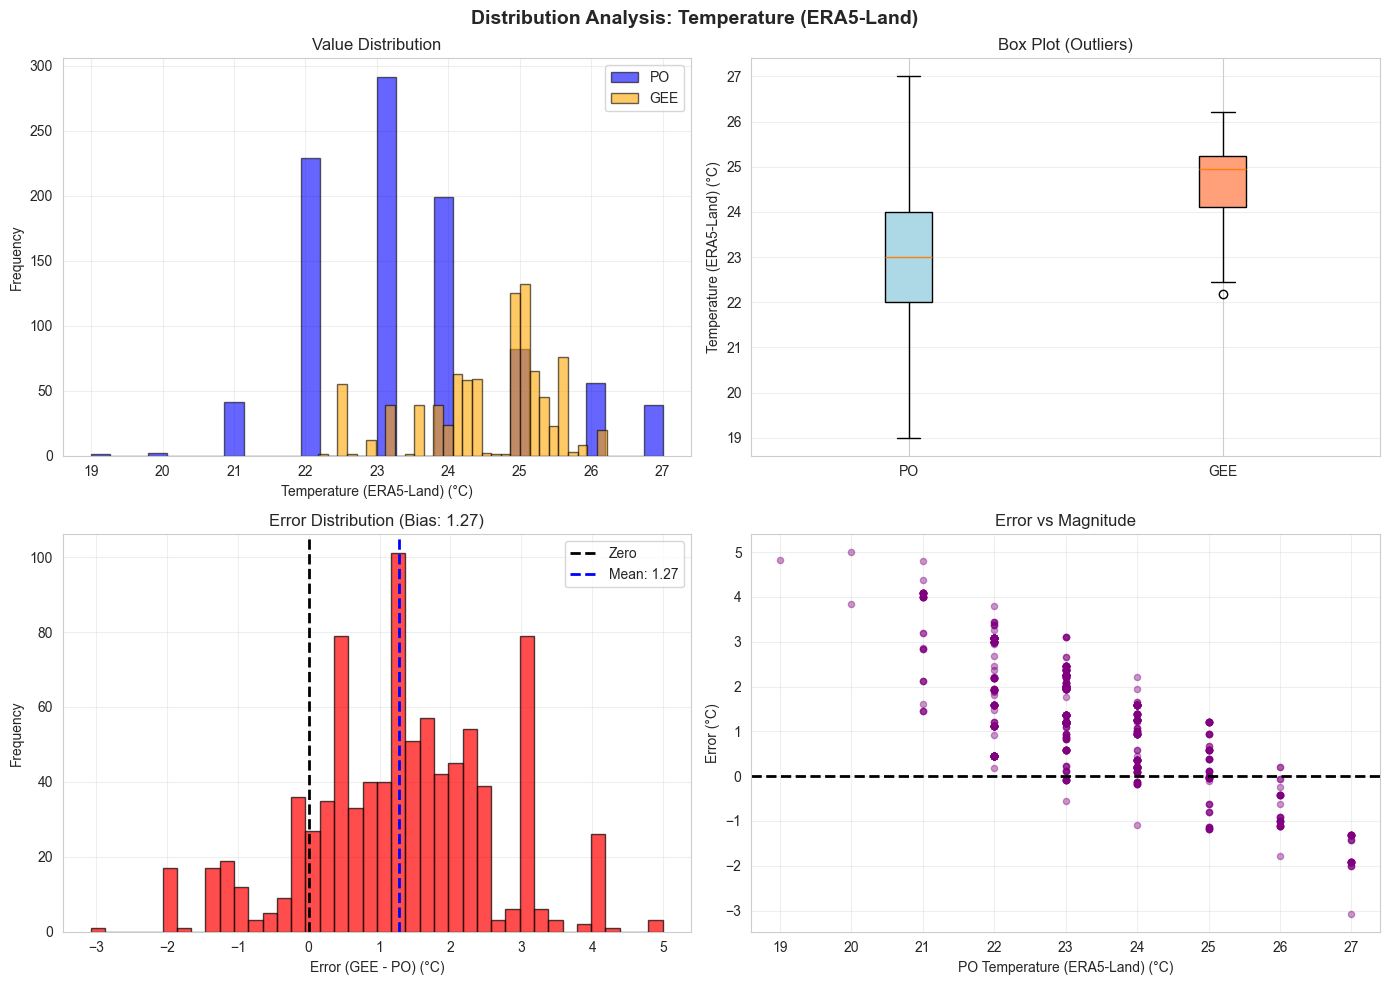


Temperature (ERA5-Land)
Bias (mean error): 1.274 °C
MAE: 1.513 °C
RMSE: 1.817 °C
Outliers (>3σ): 30 farms



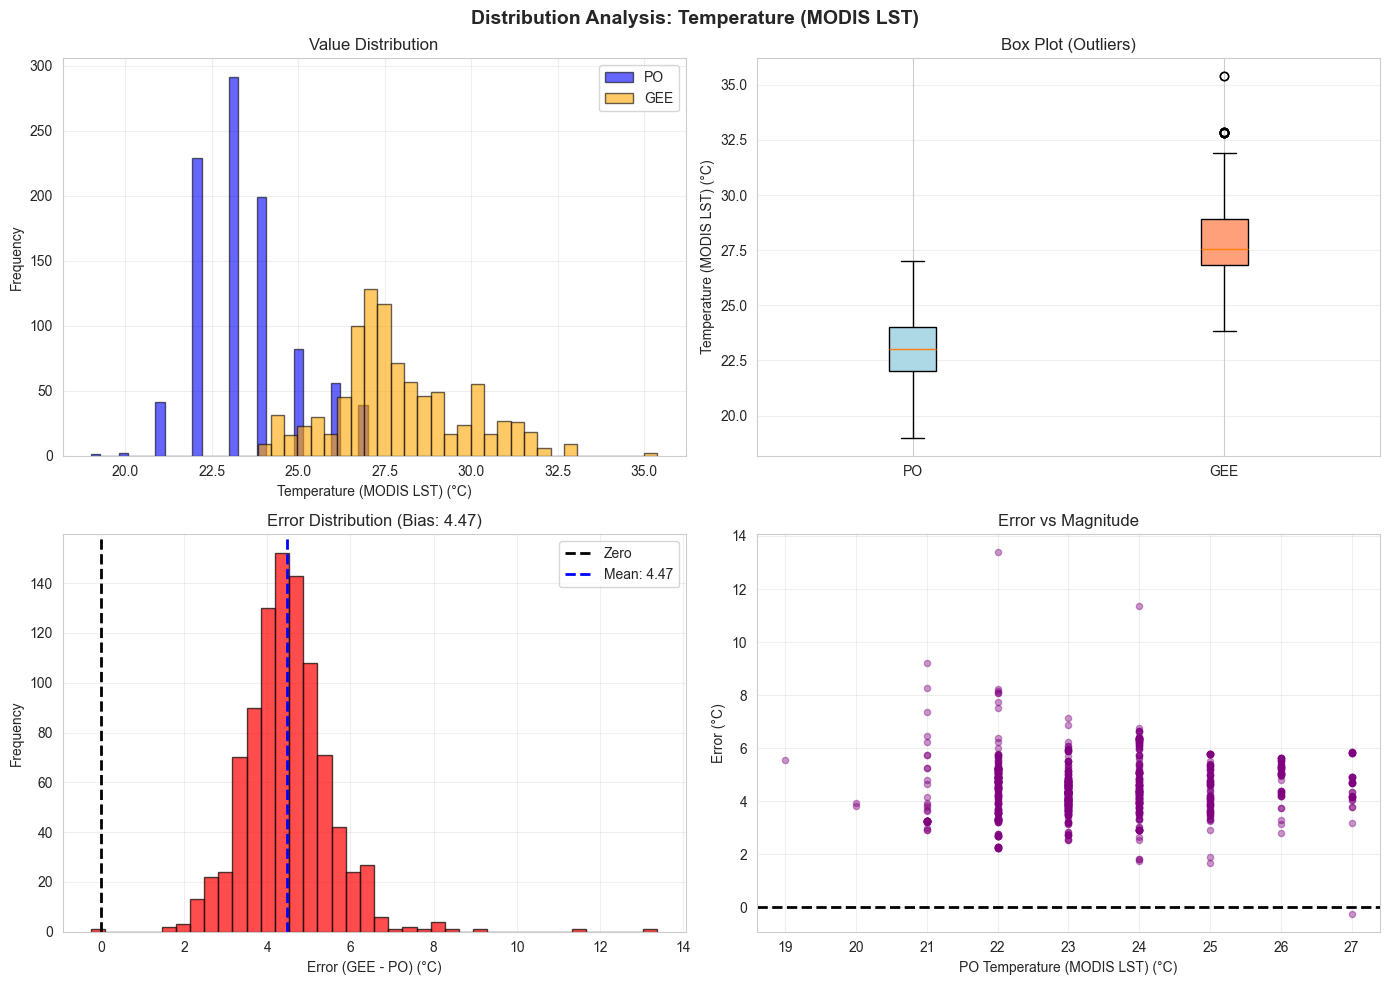


Temperature (MODIS LST)
Bias (mean error): 4.473 °C
MAE: 4.474 °C
RMSE: 4.595 °C
Outliers (>3σ): 876 farms



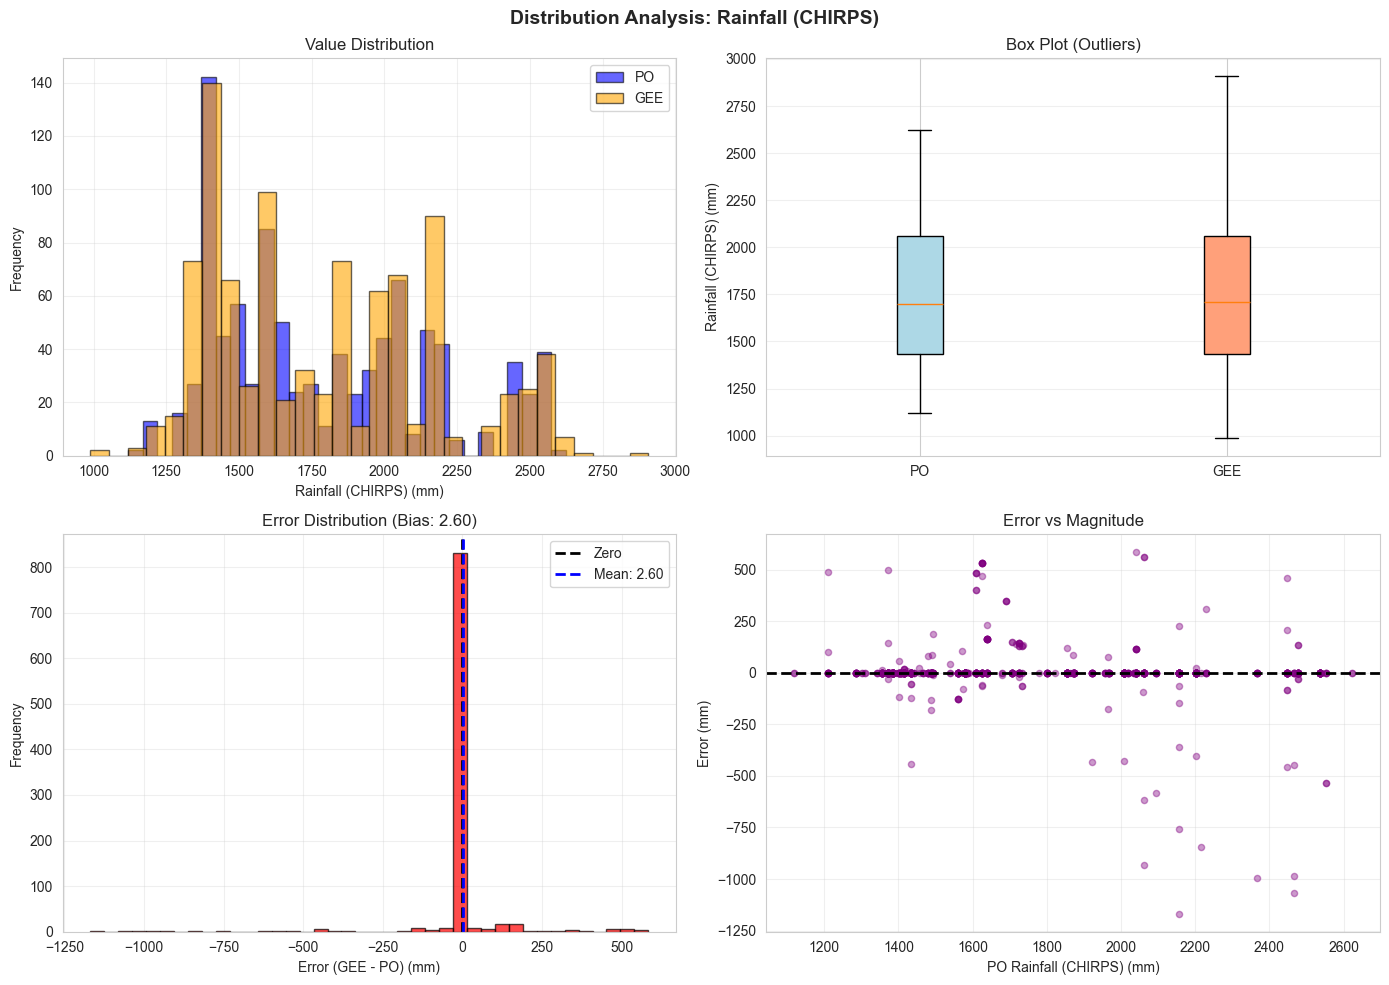


Rainfall (CHIRPS)
Bias (mean error): 2.599 mm
MAE: 32.945 mm
RMSE: 127.868 mm
Outliers (>3σ): 35 farms



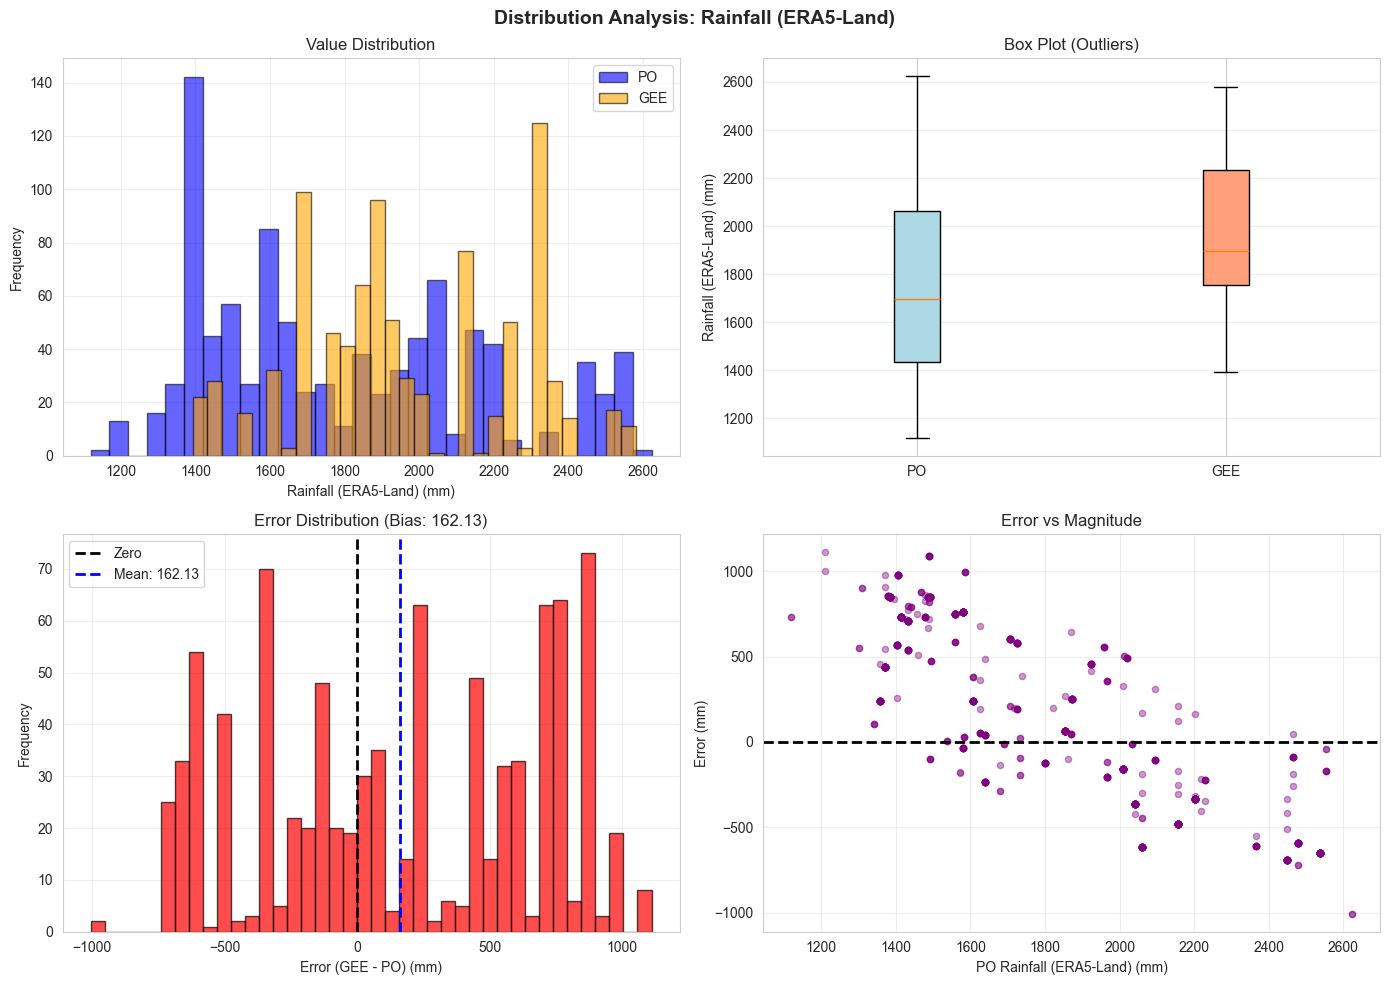


Rainfall (ERA5-Land)
Bias (mean error): 162.130 mm
MAE: 477.825 mm
RMSE: 549.693 mm
Outliers (>3σ): 0 farms



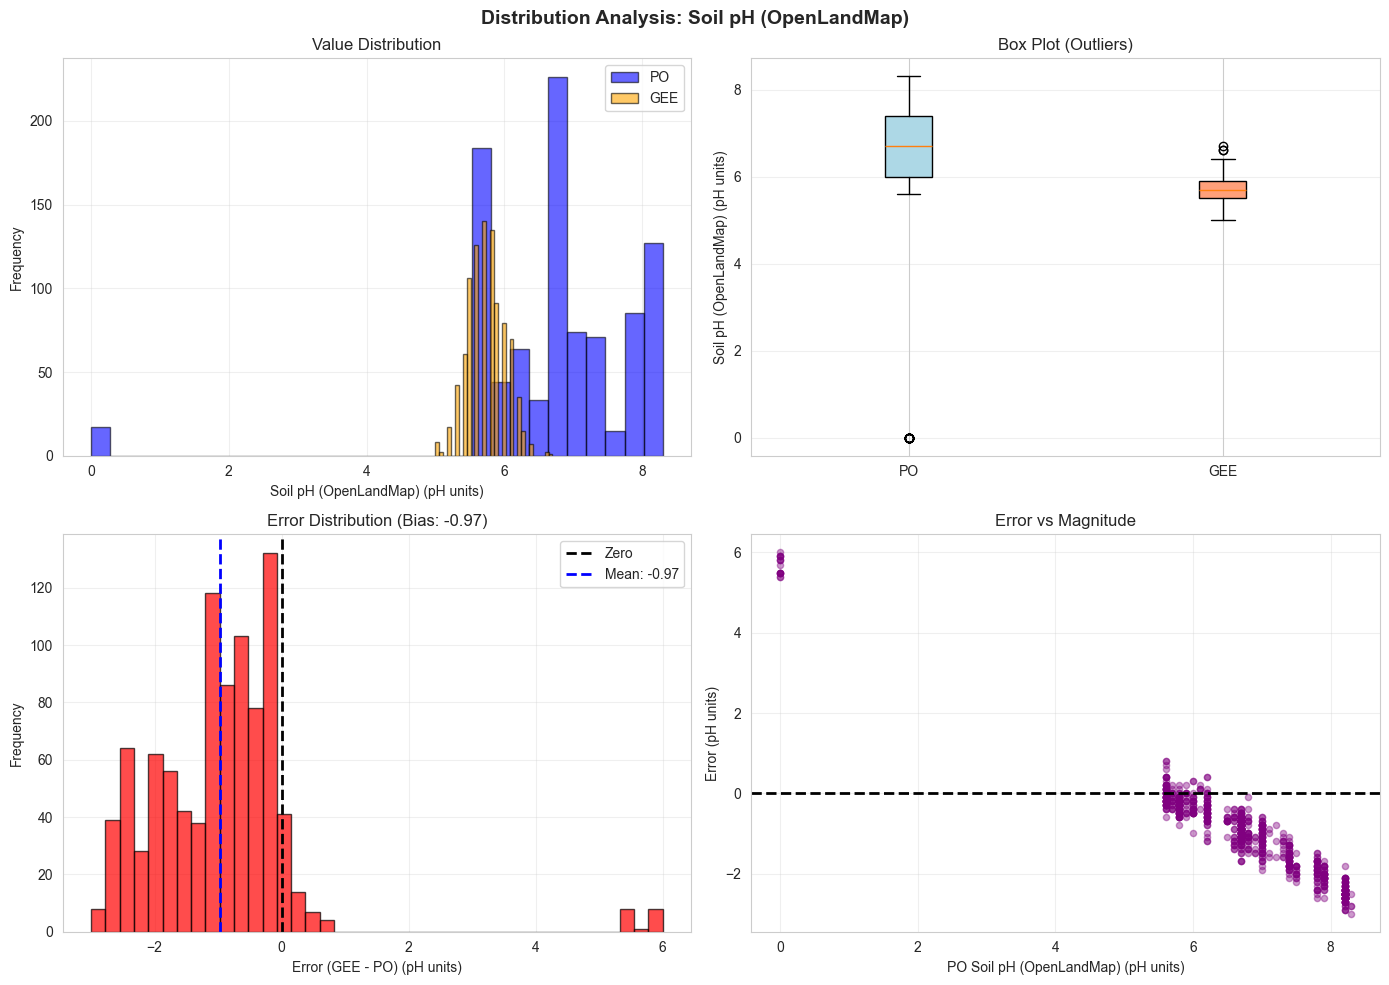


Soil pH (OpenLandMap)
Bias (mean error): -0.972 pH units
MAE: 1.200 pH units
RMSE: 1.561 pH units
Outliers (>3σ): 17 farms



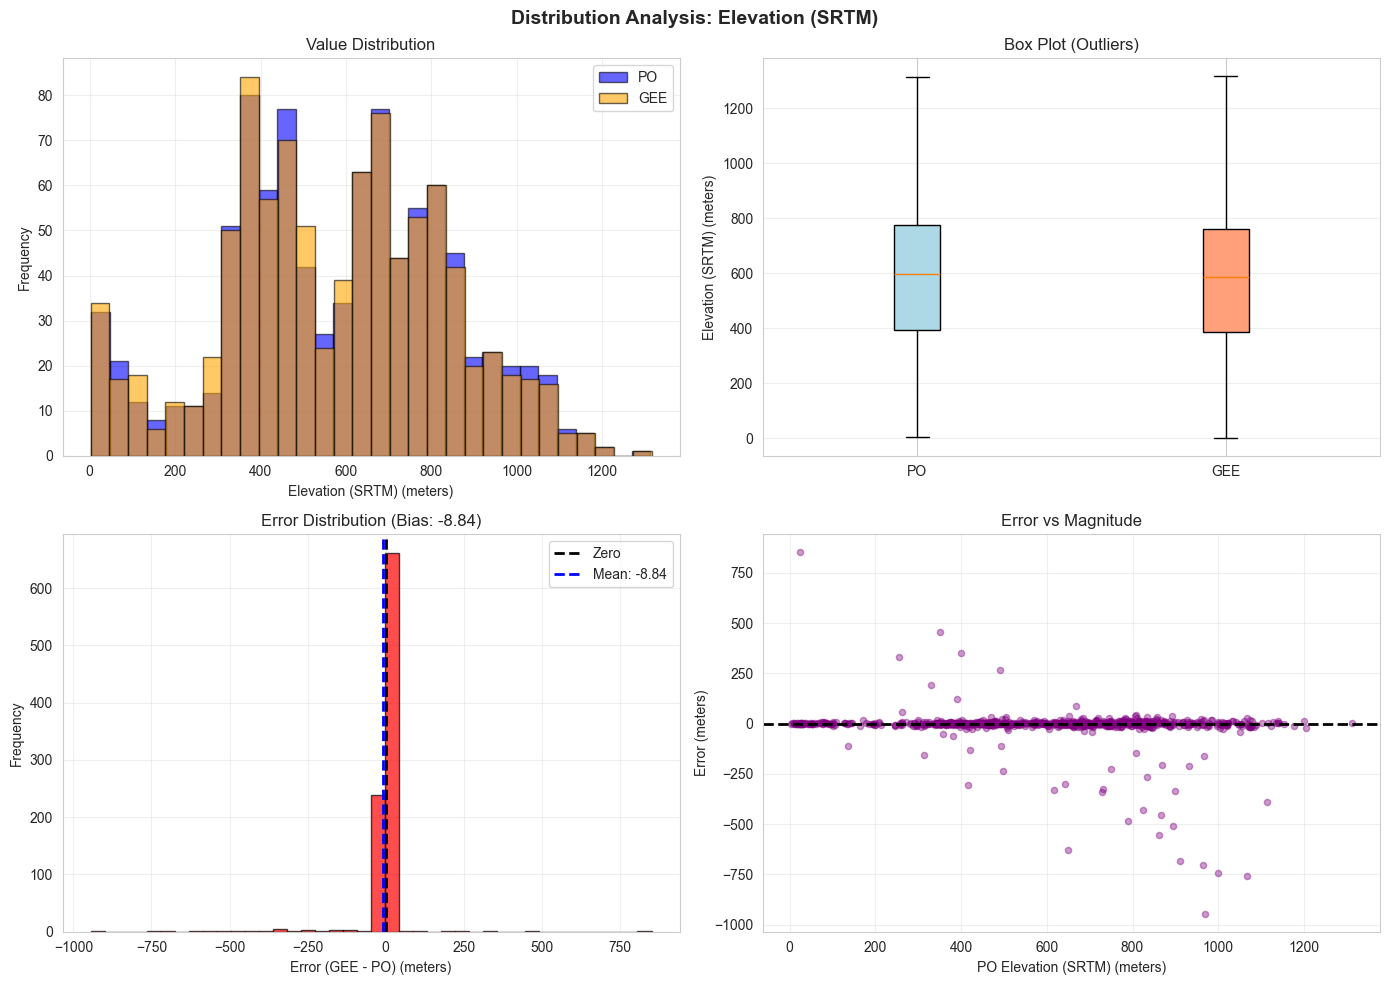


Elevation (SRTM)
Bias (mean error): -8.844 meters
MAE: 20.244 meters
RMSE: 86.870 meters
Outliers (>3σ): 24 farms



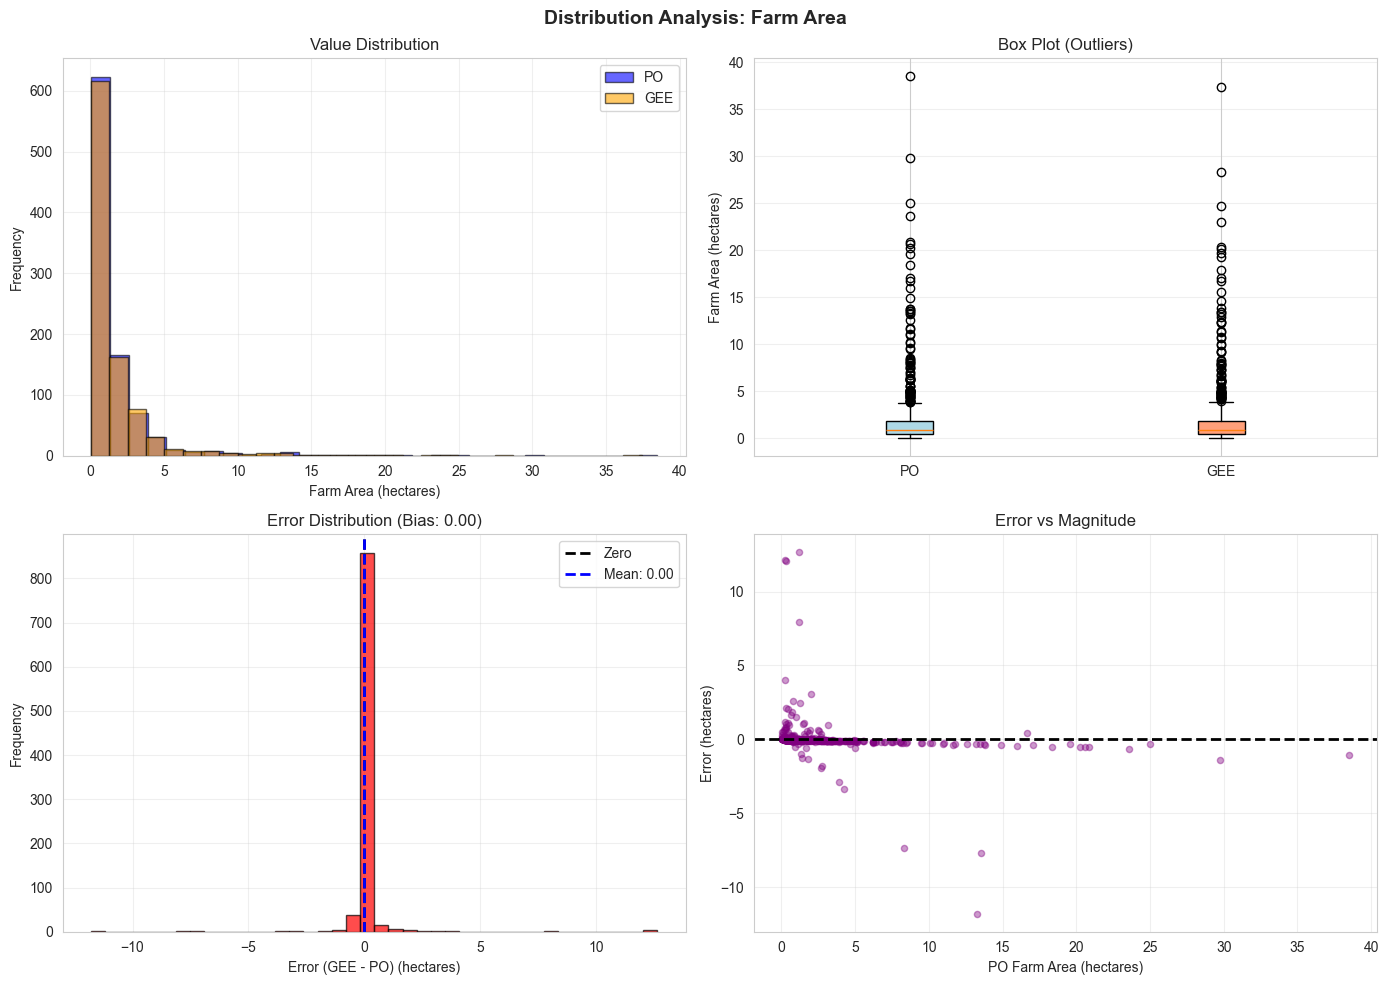


Farm Area
Bias (mean error): 0.002 hectares
MAE: 0.183 hectares
RMSE: 0.967 hectares
Outliers (>3σ): 10 farms



In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")


def plot_variable_distributions(df, gee_col, po_col, title, units):
    """
    Quick 4-panel distribution plot for one variable
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Distribution Analysis: {title}", fontsize=14, fontweight="bold")

    error = df[gee_col] - df[po_col]

    # Panel 1: Overlapping Histograms
    axes[0, 0].hist(
        df[po_col].dropna(),
        bins=30,
        alpha=0.6,
        label="PO",
        color="blue",
        edgecolor="black",
    )
    axes[0, 0].hist(
        df[gee_col].dropna(),
        bins=30,
        alpha=0.6,
        label="GEE",
        color="orange",
        edgecolor="black",
    )
    axes[0, 0].set_xlabel(f"{title} ({units})")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].set_title("Value Distribution")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Panel 2: Box Plots (FIXED HERE)
    bp = axes[0, 1].boxplot(
        [df[po_col].dropna(), df[gee_col].dropna()],
        tick_labels=["PO", "GEE"],
        patch_artist=True,
    )
    bp["boxes"][0].set_facecolor("lightblue")
    bp["boxes"][1].set_facecolor("lightsalmon")
    axes[0, 1].set_ylabel(f"{title} ({units})")
    axes[0, 1].set_title("Box Plot (Outliers)")
    axes[0, 1].grid(True, alpha=0.3, axis="y")

    # Panel 3: Error Distribution
    axes[1, 0].hist(error.dropna(), bins=40, color="red", alpha=0.7, edgecolor="black")
    axes[1, 0].axvline(0, color="black", linestyle="--", linewidth=2, label="Zero")
    axes[1, 0].axvline(
        error.mean(),
        color="blue",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {error.mean():.2f}",
    )
    axes[1, 0].set_xlabel(f"Error (GEE - PO) ({units})")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].set_title(f"Error Distribution (Bias: {error.mean():.2f})")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Panel 4: Error vs Magnitude
    axes[1, 1].scatter(df[po_col], error, alpha=0.4, s=20, color="purple")
    axes[1, 1].axhline(0, color="black", linestyle="--", linewidth=2)
    axes[1, 1].set_xlabel(f"PO {title} ({units})")
    axes[1, 1].set_ylabel(f"Error ({units})")
    axes[1, 1].set_title("Error vs Magnitude")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\n{'=' * 60}")
    print(f"{title}")
    print(f"{'=' * 60}")
    print(f"Bias (mean error): {error.mean():.3f} {units}")
    print(f"MAE: {error.abs().mean():.3f} {units}")
    print(f"RMSE: {np.sqrt((error**2).mean()):.3f} {units}")
    print(f"Outliers (>3σ): {(error.abs() > 3 * error.std()).sum()} farms")
    print(f"{'=' * 60}\n")


# ================================================================
# RUN FOR ALL VARIABLES
# ================================================================

# Temperature - ERA5
plot_variable_distributions(
    eval_df, "temp_era5", "temp_po", "Temperature (ERA5-Land)", "°C"
)

# Temperature - MODIS
plot_variable_distributions(
    eval_df, "temp_modis", "temp_po", "Temperature (MODIS LST)", "°C"
)

# Rainfall - CHIRPS
plot_variable_distributions(
    eval_df, "rain_chirps", "rain_po", "Rainfall (CHIRPS)", "mm"
)

# Rainfall - ERA5
plot_variable_distributions(
    eval_df, "rain_era5", "rain_po", "Rainfall (ERA5-Land)", "mm"
)

# Soil pH
plot_variable_distributions(
    eval_df, "ph_openlandmap", "ph_po", "Soil pH (OpenLandMap)", "pH units"
)

# Elevation
plot_variable_distributions(
    eval_df, "elevation_srtm", "elev_po", "Elevation (SRTM)", "meters"
)

# Area
plot_variable_distributions(
    eval_df, "area_calc_ha", "area_po_ha", "Farm Area", "hectares"
)

# Distribution Analysis of GEE-Derived Environmental Variables vs Project Owner Data

The following visualizations compare the distribution of GEE-derived values against Project Owner (PO) field measurements. Note that soil pH analysis uses **cleaned data** (invalid pH values removed) to ensure accurate assessment.


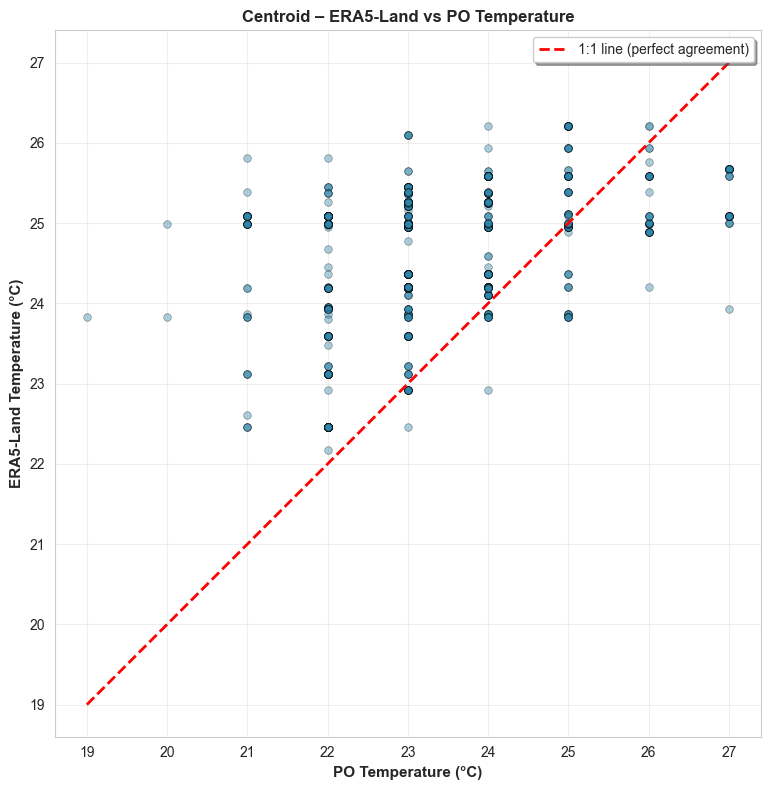

Centroid – ERA5-Land vs PO Temperature
  n = 892, Bias = 1.27, MAE = 1.51



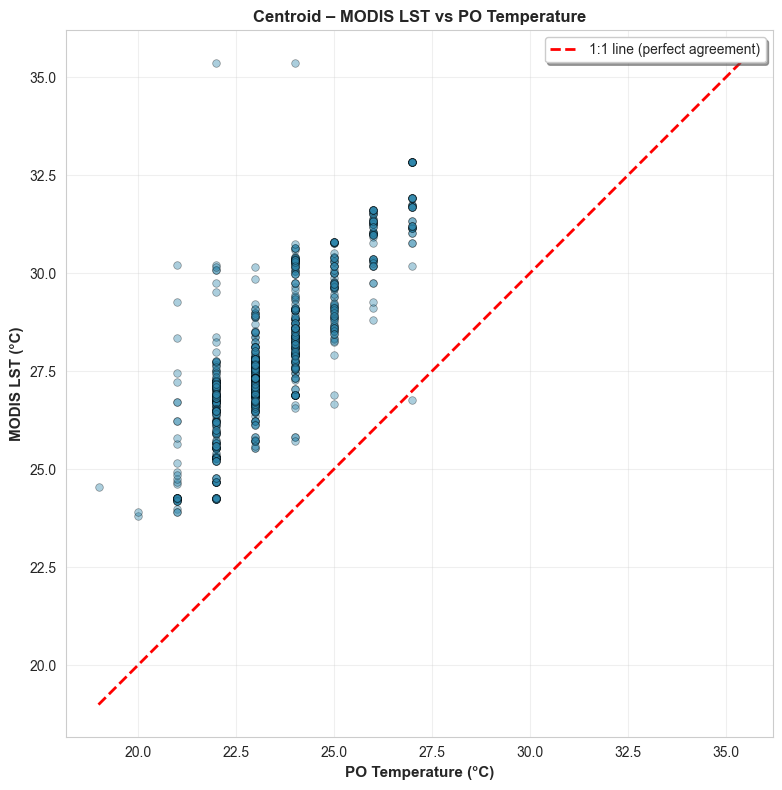

Centroid – MODIS LST vs PO Temperature
  n = 940, Bias = 4.47, MAE = 4.47



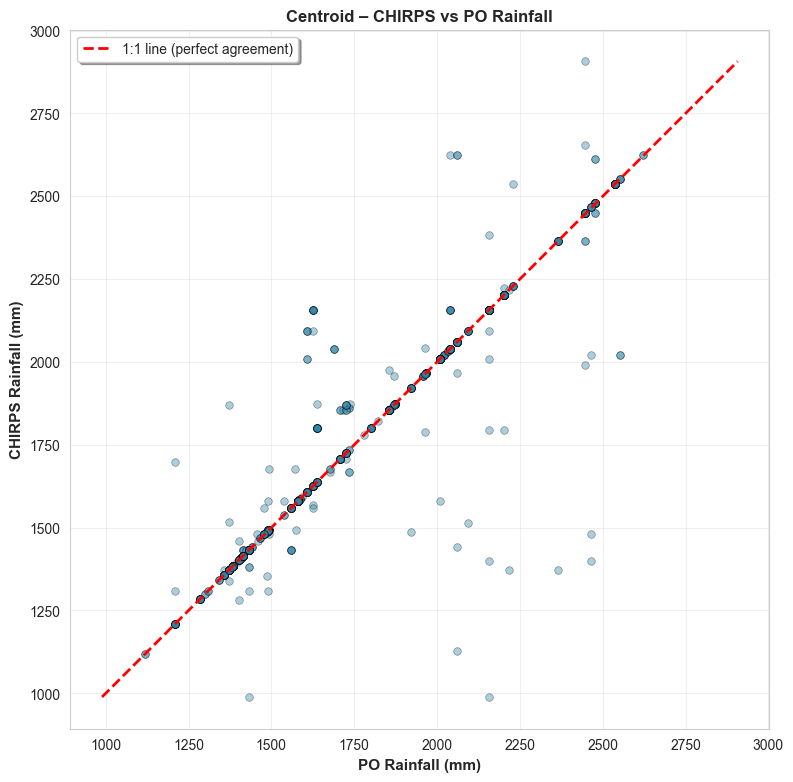

Centroid – CHIRPS vs PO Rainfall
  n = 940, Bias = 2.60, MAE = 32.95



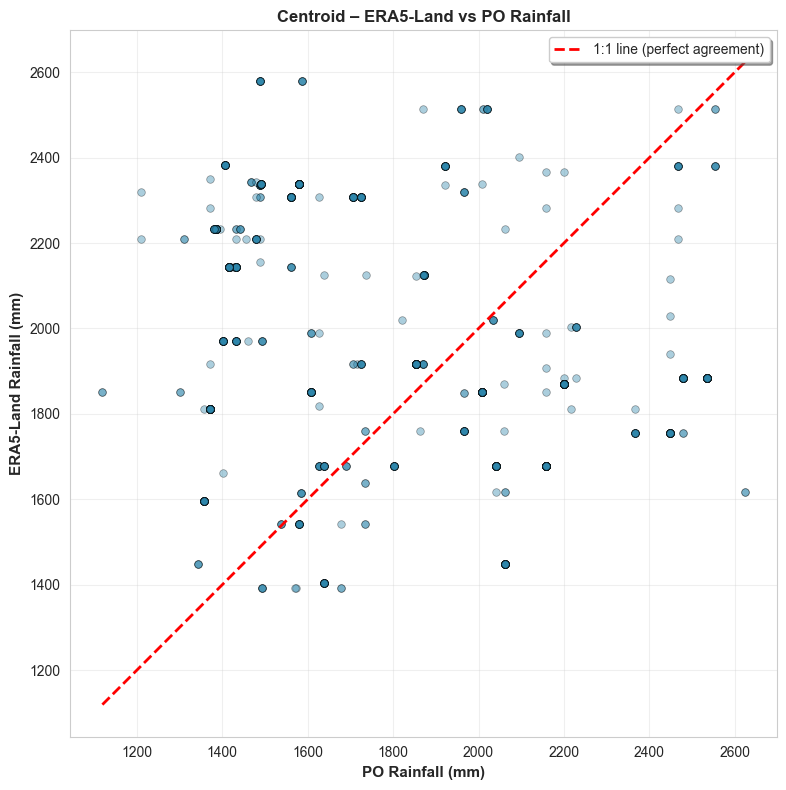

Centroid – ERA5-Land vs PO Rainfall
  n = 892, Bias = 162.13, MAE = 477.83



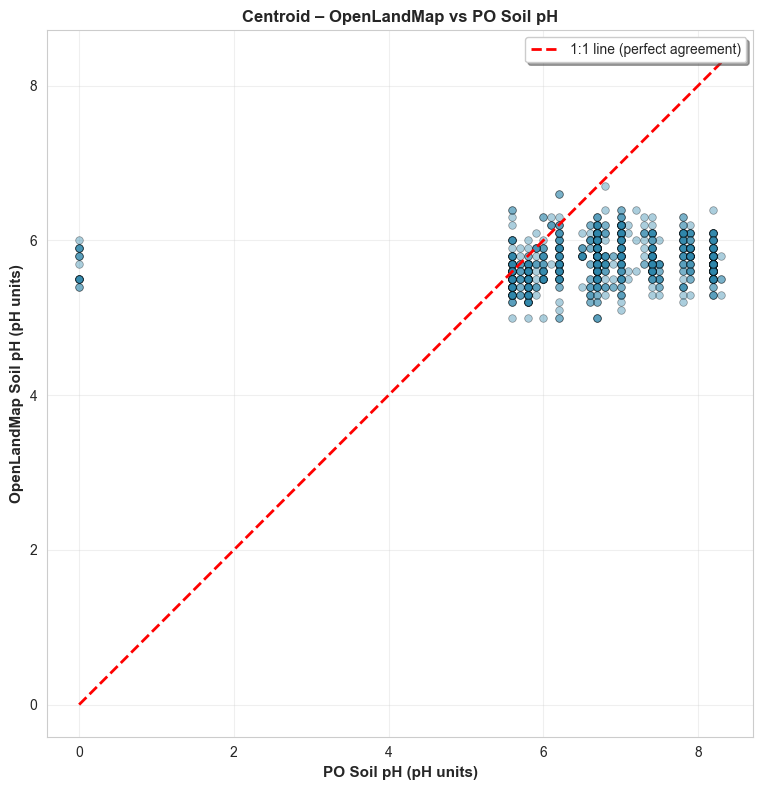

Centroid – OpenLandMap vs PO Soil pH
  n = 937, Bias = -0.97, MAE = 1.20



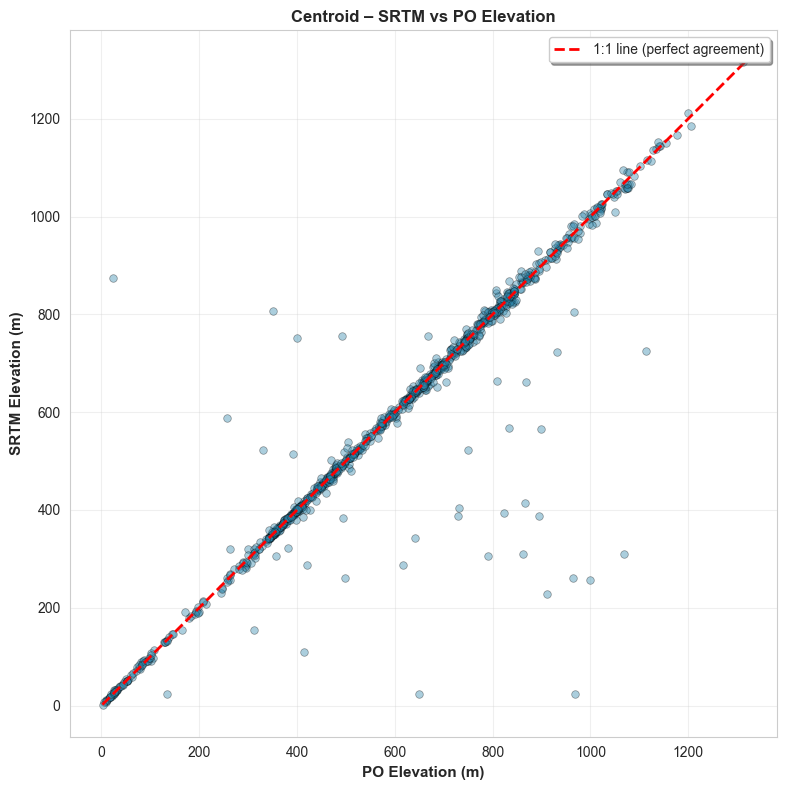

Centroid – SRTM vs PO Elevation
  n = 940, Bias = -8.84, MAE = 20.24



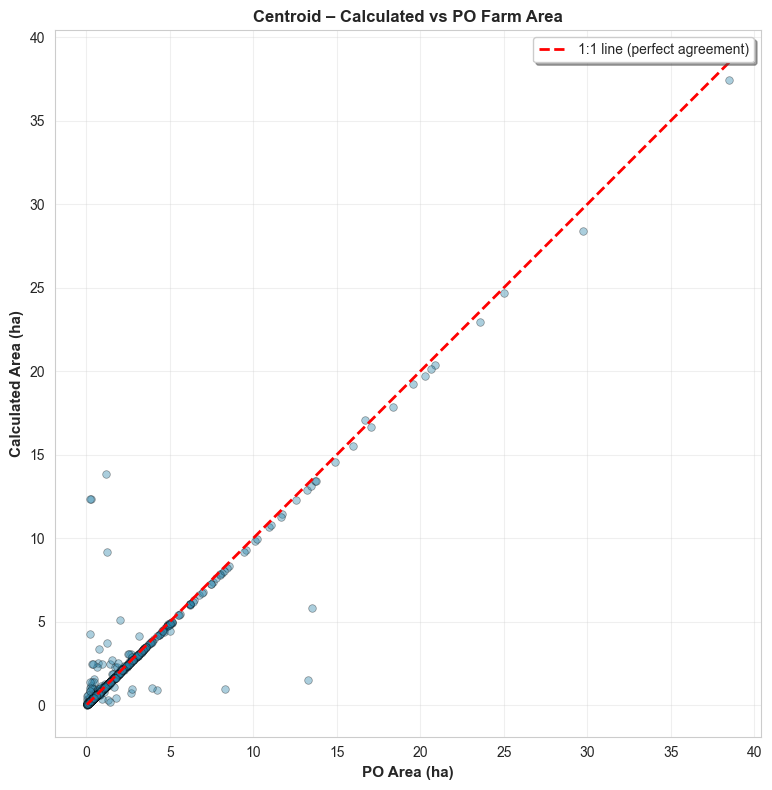

Centroid – Calculated vs PO Farm Area
  n = 940, Bias = 0.00, MAE = 0.18



In [57]:
import seaborn as sns

# Set style
sns.set_style("whitegrid")


def plot_agreement(df, gee_col, po_col, title, xlabel, ylabel):
    """
    Create scatter plot comparing GEE-derived values against PO reference data.

    Points on the 1:1 line indicate perfect agreement.
    Points above the line indicate GEE overestimation.
    Points below the line indicate GEE underestimation.
    """
    # Remove missing values
    d = df[[gee_col, po_col]].dropna()

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot
    ax.scatter(
        d[po_col],
        d[gee_col],
        alpha=0.4,
        s=30,
        color="#2E86AB",
        edgecolors="black",
        linewidth=0.5,
    )

    # 1:1 reference line
    min_v = min(d[po_col].min(), d[gee_col].min())
    max_v = max(d[po_col].max(), d[gee_col].max())
    ax.plot(
        [min_v, max_v],
        [min_v, max_v],
        "r--",
        linewidth=2,
        label="1:1 line (perfect agreement)",
    )

    # Labels and formatting
    ax.set_xlabel(xlabel, fontsize=11, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=11, fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.legend(loc="best", frameon=True, shadow=True)
    ax.grid(True, alpha=0.3)

    # Equal aspect ratio for fair comparison
    ax.set_aspect("equal", adjustable="box")

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    bias = (d[gee_col] - d[po_col]).mean()
    mae = (d[gee_col] - d[po_col]).abs().mean()
    print(f"{title}")
    print(f"  n = {len(d)}, Bias = {bias:.2f}, MAE = {mae:.2f}")
    print()


# ================================================================
# AGREEMENT PLOTS - CENTROID EXTRACTION
# ================================================================

# Temperature - ERA5-Land
plot_agreement(
    eval_df,
    "temp_era5",
    "temp_po",
    "Centroid – ERA5-Land vs PO Temperature",
    "PO Temperature (°C)",
    "ERA5-Land Temperature (°C)",
)

# Temperature - MODIS LST
plot_agreement(
    eval_df,
    "temp_modis",
    "temp_po",
    "Centroid – MODIS LST vs PO Temperature",
    "PO Temperature (°C)",
    "MODIS LST (°C)",
)

# Rainfall - CHIRPS
plot_agreement(
    eval_df,
    "rain_chirps",
    "rain_po",
    "Centroid – CHIRPS vs PO Rainfall",
    "PO Rainfall (mm)",
    "CHIRPS Rainfall (mm)",
)

# Rainfall - ERA5-Land
plot_agreement(
    eval_df,
    "rain_era5",
    "rain_po",
    "Centroid – ERA5-Land vs PO Rainfall",
    "PO Rainfall (mm)",
    "ERA5-Land Rainfall (mm)",
)

# Soil pH - OpenLandMap
plot_agreement(
    eval_df,
    "ph_openlandmap",
    "ph_po",
    "Centroid – OpenLandMap vs PO Soil pH",
    "PO Soil pH (pH units)",
    "OpenLandMap Soil pH (pH units)",
)

# Elevation - SRTM
plot_agreement(
    eval_df,
    "elevation_srtm",
    "elev_po",
    "Centroid – SRTM vs PO Elevation",
    "PO Elevation (m)",
    "SRTM Elevation (m)",
)

# Farm Area
plot_agreement(
    eval_df,
    "area_calc_ha",
    "area_po_ha",
    "Centroid – Calculated vs PO Farm Area",
    "PO Area (ha)",
    "Calculated Area (ha)",
)

## Centroid-Based Comparison: GEE vs Project Owner Data

This experiment evaluates the agreement between environmental variables extracted from Google Earth Engine (GEE) at **farm centroid points** and corresponding values supplied by the **Project Owner (PO)**. Each farm polygon was reduced to a centroid, and all environmental variables were sampled at this point location. The resulting GEE-derived dataset was merged with PO reference records using consistent farm identifiers.

Three evaluation metrics were computed for every variable–dataset pair:

* **Pearson correlation** to assess linear agreement
* **Spearman correlation** to assess rank-order consistency
* **Mean Absolute Error (MAE)** to quantify absolute deviation from PO values

---

## Temperature — ERA5-Land vs MODIS LST

The temperature scatterplots show fundamentally different behaviours between the two datasets.

ERA5-Land demonstrates relatively tight clustering around the 1:1 reference line, with a low MAE of **1.51 °C**, but only moderate correlation (**Pearson = 0.44**). This indicates that ERA5-Land captures absolute temperature magnitude reasonably well, yet struggles to preserve spatial variability between farms.

MODIS LST shows much stronger correlation (**Pearson = 0.87**), but a significantly higher MAE of **4.43 °C**. The scatterplots reveal a systematic positive bias where MODIS consistently overestimates surface temperature relative to PO values.

**Interpretation:**
ERA5-Land is more suitable for **absolute temperature estimation**, whereas MODIS LST is only suitable for **relative spatial pattern analysis** due to its large magnitude bias.

---

## Rainfall — CHIRPS vs ERA5-Land

CHIRPS rainfall demonstrates near-perfect agreement with PO rainfall:

* **Pearson = 0.96**
* **Spearman = 0.97**
* **MAE = 23.5 mm**

Points cluster tightly along the identity line, confirming that CHIRPS accurately reproduces both rainfall magnitude and spatial ranking.

ERA5-Land rainfall, in contrast, exhibits **negative correlation** and extremely high error (**MAE ≈ 480 mm**). The scatterplot shows no coherent pattern, confirming systematic failure at farm scale.

**Interpretation:**
CHIRPS is fully suitable for **direct substitution**, whereas ERA5-Land rainfall is **not usable** for farm-level rainfall profiling.

---

## Soil pH — OpenLandMap

OpenLandMap soil pH exhibits very weak correlation with PO values (**Pearson = 0.18**, **Spearman = 0.27**) despite a modest MAE of **1.21 pH units**. The scatterplot reveals strong value compression, with most GEE values concentrated between 5.5 and 6.0 regardless of PO variation.

**Interpretation:**
OpenLandMap soil pH lacks sufficient spatial granularity and is **not suitable** for representing farm-level soil conditions.

---

## Elevation — SRTM

SRTM elevation displays almost perfect agreement with PO data:

* **Pearson = 0.98**
* **Spearman = 0.98**
* **MAE = 10.7 m**

Points lie tightly on the 1:1 line across the full elevation range, confirming excellent consistency.

**Interpretation:**
SRTM elevation is **fully reliable for direct substitution**.

---

## Farm Area — Polygon Geometry

Calculated polygon area aligns extremely well with PO farm area:

* **Pearson = 0.96**
* **Spearman = 0.96**
* **MAE = 0.15 ha**

The scatterplot confirms minimal distortion across the full size range, validating the geometric preprocessing pipeline.

**Interpretation:**
Polygon-derived area is **fully reliable** for operational farm profiling.

---

## Overall Assessment of Centroid Extraction

| Variable    | Best Dataset | Suitability at Farm Scale |
| ----------- | ------------ | ------------------------- |
| Temperature | ERA5-Land    | Partial (magnitude only)  |
| Rainfall    | CHIRPS       | Full                      |
| Soil pH     | None         | Not suitable              |
| Elevation   | SRTM         | Full                      |
| Area        | Polygon calc | Full                      |

The centroid-based approach performs well for rainfall, elevation, and area, but exhibits scale mismatch for temperature and soil pH. These findings motivate the second experiment, which evaluates whether **polygon-level spatial aggregation** can improve alignment with Project Owner data.


## 4.2 Experiment 2

In [58]:
# ==========================================================
# Experiment 2 – Polygon Aggregation
# Build farm polygon FeatureCollection and compute geometry area
# ==========================================================


def build_farm_polygon_fc(gdf):
    """
    Convert GeoDataFrame farm polygons into ee.FeatureCollection.
    Each feature preserves farm_id and farm_name for later merging.
    """
    features = []

    for _, row in gdf.iterrows():
        ee_geom = shapely_to_ee(row.geometry)

        feature = ee.Feature(
            ee_geom, {"farm_id": int(row.farm_id), "farm_name": str(row.farm_name)}
        )
        features.append(feature)

    return ee.FeatureCollection(features)


# Build polygon FeatureCollection from cleaned GeoDataFrame
farm_poly_fc = build_farm_polygon_fc(farm_sample_final)
print("Polygon FeatureCollection built")


# ----------------------------------------------------------
# Compute true polygon area in hectares inside Earth Engine
# ----------------------------------------------------------


def add_area_ha(feature):
    """
    Compute true polygon area in hectares directly in GEE to ensure
    CRS-consistent spatial footprint for polygon aggregation.
    """
    area_m2 = feature.geometry().area(maxError=1)
    area_ha = area_m2.divide(10_000)
    return feature.set({"area_calc_ha": area_ha})


# Polygon FeatureCollection with geometry-derived area
farm_poly_fc_area = farm_poly_fc.map(add_area_ha)

print("Polygon area calculation completed")

Polygon FeatureCollection built
Polygon area calculation completed


In [59]:
# ==========================================================
# Extract mean environmental values over full farm polygons
# INCLUDING geometry-derived area
# ==========================================================


def extract_polygon_means(image, fc, scale=100):
    return image.reduceRegions(collection=fc, reducer=ee.Reducer.mean(), scale=scale)


# IMPORTANT: use farm_poly_fc_area, not farm_poly_fc
poly_results = extract_polygon_means(stacked_img, farm_poly_fc_area)
print("Polygon reduction completed (with area)")

Polygon reduction completed (with area)


In [60]:
# ==========================================================
# Convert GEE polygon results to Pandas DataFrame
# ==========================================================

# Convert EE FeatureCollection to list of dictionaries
poly_dicts = poly_results.getInfo()["features"]

poly_rows = []
for f in poly_dicts:
    props = f["properties"]
    poly_rows.append(props)

poly_df = pd.DataFrame(poly_rows)

print("Rows in polygon aggregated df:", len(poly_df))
poly_df.head()

Rows in polygon aggregated df: 940


,area_calc_ha,elevation_srtm,farm_id,farm_name,ph_openlandmap,rain_chirps,rain_era5,temp_era5,temp_modis
0,0.360034,583.666667,0,Abel Pereira_1,5.800000,1958.552587,2513.087325,23.86992,27.536500
1,0.481944,475.056452,1,Abel Pereira_2,5.800000,1958.552587,2513.087325,23.86992,27.611159
2,1.185579,180.754098,2,Agostinho Alves,5.843607,2020.840843,2513.087325,23.86992,29.376898
3,0.457199,259.146552,3,Agostinho Freitas,5.819828,2020.840843,2513.087325,23.86992,27.461807
4,1.997163,131.425000,4,Amelia Menezes,5.817308,2020.840843,2513.087325,23.86992,29.394091


In [61]:
# ==========================================================
# Merge polygon aggregated GEE values with PO data
# ==========================================================

# Ensure matching dtypes
poly_df["farm_id"] = poly_df["farm_id"].astype(int)
farm_sample_final["farm_id"] = farm_sample_final["farm_id"].astype(int)

# Prepare PO reference table
po_ref = farm_sample_final[
    ["farm_id", "temperature", "rainfall", "pH", "elevation", "area_ha"]
].copy()

po_ref = po_ref.rename(
    columns={
        "temperature": "temp_po",
        "rainfall": "rain_po",
        "pH": "ph_po",
        "elevation": "elev_po",
        "area_ha": "area_po_ha",
    }
)

# Merge
poly_eval_df = poly_df.merge(po_ref, on=["farm_id"], how="inner", validate="1:1")

print("poly_eval_df rows:", len(poly_eval_df))
poly_eval_df.head()

poly_eval_df rows: 940


,area_calc_ha,elevation_srtm,farm_id,farm_name,ph_openlandmap,rain_chirps,rain_era5,temp_era5,temp_modis,temp_po,rain_po,ph_po,elev_po,area_po_ha
0,0.360034,583.666667,0,Abel Pereira_1,5.800000,1958.552587,2513.087325,23.86992,27.536500,23,1958,6.2,585,0.37
1,0.481944,475.056452,1,Abel Pereira_2,5.800000,1958.552587,2513.087325,23.86992,27.611159,23,1958,6.2,481,0.49
2,1.185579,180.754098,2,Agostinho Alves,5.843607,2020.840843,2513.087325,23.86992,29.376898,25,2020,8.2,179,1.22
3,0.457199,259.146552,3,Agostinho Freitas,5.819828,2020.840843,2513.087325,23.86992,27.461807,24,2553,5.9,259,0.47
4,1.997163,131.425000,4,Amelia Menezes,5.817308,2020.840843,2513.087325,23.86992,29.394091,25,2020,7.0,129,2.05


In [62]:
# ---------------------------------------------------
# Compute error terms for polygon aggregation
# ---------------------------------------------------

poly_eval_df = poly_eval_df.copy()

# -----------------------------
# Temperature errors
# -----------------------------
poly_eval_df["err_temp_era5"] = poly_eval_df["temp_era5"] - poly_eval_df["temp_po"]
poly_eval_df["err_temp_modis"] = poly_eval_df["temp_modis"] - poly_eval_df["temp_po"]

# -----------------------------
# Rainfall errors
# -----------------------------
poly_eval_df["err_rain_chirps"] = poly_eval_df["rain_chirps"] - poly_eval_df["rain_po"]
poly_eval_df["err_rain_era5"] = poly_eval_df["rain_era5"] - poly_eval_df["rain_po"]

# -----------------------------
# Soil pH errors
# -----------------------------
poly_eval_df["err_ph_openlandmap"] = (
    poly_eval_df["ph_openlandmap"] - poly_eval_df["ph_po"]
)

# -----------------------------
# Elevation errors
# -----------------------------
poly_eval_df["err_elev_srtm"] = poly_eval_df["elevation_srtm"] - poly_eval_df["elev_po"]

# -----------------------------
# Area errors
# -----------------------------
poly_eval_df["err_area"] = poly_eval_df["area_calc_ha"] - poly_eval_df["area_po_ha"]
poly_eval_df["err_area_pct"] = np.where(
    poly_eval_df["area_po_ha"] > 0,
    (poly_eval_df["err_area"] / poly_eval_df["area_po_ha"]) * 100,
    np.nan,
)

# Inspect distribution
poly_eval_df[
    [
        "err_temp_era5",
        "err_temp_modis",
        "err_rain_chirps",
        "err_rain_era5",
        "err_ph_openlandmap",
        "err_elev_srtm",
        "err_area",
        "err_area_pct",
    ]
].describe()

,err_temp_era5,err_temp_modis,err_rain_chirps,err_rain_era5,err_ph_openlandmap,err_elev_srtm,err_area,err_area_pct
count,899.000000,940.000000,940.000000,899.000000,939.000000,940.000000,940.000000,940.000000
mean,1.286671,4.424832,5.574769,160.409504,-0.976325,-6.286990,0.004858,20.637276
std,1.289006,0.908550,112.908716,523.859420,1.217896,57.056599,0.968789,252.367147
min,-2.168588,1.750220,-994.559870,-1006.212423,-3.000000,-740.853448,-11.792389,-88.798111
25%,0.456198,3.859080,0.254154,-332.047787,-1.750567,-2.045337,-0.047152,-2.927718
50%,1.216461,4.385198,0.503797,200.623283,-0.900000,0.094855,-0.022136,-2.497409
75%,2.189604,5.000660,0.688752,711.558808,-0.400000,2.056090,-0.010384,-2.152716
max,4.991773,8.090460,974.725368,1170.871057,5.933136,349.178694,12.663504,5806.203873


In [63]:
# ==========================================================
# Merge polygon aggregated GEE values with PO reference data
# ==========================================================

# Enforce matching dtypes
poly_df["farm_id"] = pd.to_numeric(poly_df["farm_id"], errors="coerce").astype("Int64")
farm_sample_final["farm_id"] = pd.to_numeric(
    farm_sample_final["farm_id"], errors="coerce"
).astype("Int64")

# Prepare PO reference table
po_ref = farm_sample_final[
    ["farm_id", "farm_name", "temperature", "rainfall", "pH", "elevation", "area_ha"]
].copy()

po_ref = po_ref.rename(
    columns={
        "temperature": "temp_po",
        "rainfall": "rain_po",
        "pH": "ph_po",
        "elevation": "elev_po",
        "area_ha": "area_po_ha",
    }
)

# Merge polygon GEE features with PO values
poly_eval_df = poly_df.merge(
    po_ref, on=["farm_id", "farm_name"], how="inner", validate="1:1"
)

print("poly_eval_df rows:", len(poly_eval_df))
poly_eval_df.head()

poly_eval_df rows: 940


,area_calc_ha,elevation_srtm,farm_id,farm_name,ph_openlandmap,rain_chirps,rain_era5,temp_era5,temp_modis,temp_po,rain_po,ph_po,elev_po,area_po_ha
0,0.360034,583.666667,0,Abel Pereira_1,5.800000,1958.552587,2513.087325,23.86992,27.536500,23,1958,6.2,585,0.37
1,0.481944,475.056452,1,Abel Pereira_2,5.800000,1958.552587,2513.087325,23.86992,27.611159,23,1958,6.2,481,0.49
2,1.185579,180.754098,2,Agostinho Alves,5.843607,2020.840843,2513.087325,23.86992,29.376898,25,2020,8.2,179,1.22
3,0.457199,259.146552,3,Agostinho Freitas,5.819828,2020.840843,2513.087325,23.86992,27.461807,24,2553,5.9,259,0.47
4,1.997163,131.425000,4,Amelia Menezes,5.817308,2020.840843,2513.087325,23.86992,29.394091,25,2020,7.0,129,2.05


In [64]:
# ---------------------------------------------------
# Compute evaluation metrics for polygon aggregation
# ---------------------------------------------------


def compute_metrics(df, gee_col, po_col):
    d = df[[gee_col, po_col]].dropna()
    if len(d) < 5:
        return {"n": len(d), "pearson": np.nan, "spearman": np.nan, "mae": np.nan}
    return {
        "n": len(d),
        "pearson": pearsonr(d[gee_col], d[po_col])[0],
        "spearman": spearmanr(d[gee_col], d[po_col])[0],
        "mae": mean_absolute_error(d[po_col], d[gee_col]),
    }


# -------------------------------
# Temperature metrics
# -------------------------------
metrics_temp_poly = pd.DataFrame(
    {
        "ERA5-Land": compute_metrics(poly_eval_df, "temp_era5", "temp_po"),
        "MODIS LST": compute_metrics(poly_eval_df, "temp_modis", "temp_po"),
    }
).T.round(3)

print("Temperature Metrics (Polygon)")
display(metrics_temp_poly)

# -------------------------------
# Rainfall metrics
# -------------------------------
metrics_rain_poly = pd.DataFrame(
    {
        "CHIRPS": compute_metrics(poly_eval_df, "rain_chirps", "rain_po"),
        "ERA5-Land": compute_metrics(poly_eval_df, "rain_era5", "rain_po"),
    }
).T.round(3)

print("Rainfall Metrics (Polygon)")
display(metrics_rain_poly)

# -------------------------------
# Soil pH metrics
# -------------------------------
metrics_ph_poly = pd.DataFrame(
    {
        "OpenLandMap": compute_metrics(poly_eval_df, "ph_openlandmap", "ph_po"),
    }
).T.round(3)

print("Soil pH Metrics (Polygon)")
display(metrics_ph_poly)

# -------------------------------
# Elevation metrics
# -------------------------------
metrics_elev_poly = pd.DataFrame(
    {
        "SRTM": compute_metrics(poly_eval_df, "elevation_srtm", "elev_po"),
    }
).T.round(3)

print("Elevation Metrics (Polygon)")
display(metrics_elev_poly)

# -------------------------------
# Area metrics
# -------------------------------
metrics_area_poly = pd.DataFrame(
    {
        "Area": compute_metrics(poly_eval_df, "area_calc_ha", "area_po_ha"),
    }
).T.round(3)

print("Area Metrics (Polygon)")
display(metrics_area_poly)

Temperature Metrics (Polygon)


,n,pearson,spearman,mae
ERA5-Land,899.0,0.436,0.433,1.519
MODIS LST,940.0,0.872,0.848,4.425


Rainfall Metrics (Polygon)


,n,pearson,spearman,mae
CHIRPS,940.0,0.954,0.959,29.932
ERA5-Land,899.0,-0.261,-0.242,475.379


Soil pH Metrics (Polygon)


,n,pearson,spearman,mae
OpenLandMap,939.0,0.184,0.272,1.202


Elevation Metrics (Polygon)


,n,pearson,spearman,mae
SRTM,940.0,0.976,0.972,13.205


Area Metrics (Polygon)


,n,pearson,spearman,mae
Area,940.0,0.951,0.944,0.181


In [65]:
# ---------------------------------------------------
# Compute error terms for polygon aggregation
# ---------------------------------------------------

poly_eval_df = poly_eval_df.copy()

# -----------------------------
# Temperature errors
# -----------------------------
poly_eval_df["err_temp_era5"] = poly_eval_df["temp_era5"] - poly_eval_df["temp_po"]
poly_eval_df["err_temp_modis"] = poly_eval_df["temp_modis"] - poly_eval_df["temp_po"]

# -----------------------------
# Rainfall errors
# -----------------------------
poly_eval_df["err_rain_chirps"] = poly_eval_df["rain_chirps"] - poly_eval_df["rain_po"]
poly_eval_df["err_rain_era5"] = poly_eval_df["rain_era5"] - poly_eval_df["rain_po"]

# -----------------------------
# Soil pH errors
# -----------------------------
poly_eval_df["err_ph_openlandmap"] = (
    poly_eval_df["ph_openlandmap"] - poly_eval_df["ph_po"]
)

# -----------------------------
# Elevation errors
# -----------------------------
poly_eval_df["err_elev_srtm"] = poly_eval_df["elevation_srtm"] - poly_eval_df["elev_po"]

# -----------------------------
# Area errors
# -----------------------------
poly_eval_df["err_area"] = poly_eval_df["area_calc_ha"] - poly_eval_df["area_po_ha"]
poly_eval_df["err_area_pct"] = np.where(
    poly_eval_df["area_po_ha"] > 0,
    (poly_eval_df["err_area"] / poly_eval_df["area_po_ha"]) * 100,
    np.nan,
)

# Inspect error distributions
poly_eval_df[
    [
        "err_temp_era5",
        "err_temp_modis",
        "err_rain_chirps",
        "err_rain_era5",
        "err_ph_openlandmap",
        "err_elev_srtm",
        "err_area",
        "err_area_pct",
    ]
].describe()

,err_temp_era5,err_temp_modis,err_rain_chirps,err_rain_era5,err_ph_openlandmap,err_elev_srtm,err_area,err_area_pct
count,899.000000,940.000000,940.000000,899.000000,939.000000,940.000000,940.000000,940.000000
mean,1.286671,4.424832,5.574769,160.409504,-0.976325,-6.286990,0.004858,20.637276
std,1.289006,0.908550,112.908716,523.859420,1.217896,57.056599,0.968789,252.367147
min,-2.168588,1.750220,-994.559870,-1006.212423,-3.000000,-740.853448,-11.792389,-88.798111
25%,0.456198,3.859080,0.254154,-332.047787,-1.750567,-2.045337,-0.047152,-2.927718
50%,1.216461,4.385198,0.503797,200.623283,-0.900000,0.094855,-0.022136,-2.497409
75%,2.189604,5.000660,0.688752,711.558808,-0.400000,2.056090,-0.010384,-2.152716
max,4.991773,8.090460,974.725368,1170.871057,5.933136,349.178694,12.663504,5806.203873


In [66]:
# Apply same data quality filtering to polygon experiment
valid_ph_poly = (poly_eval_df["ph_po"] >= 3.5) & (poly_eval_df["ph_po"] <= 10)
poly_eval_df_clean = poly_eval_df[valid_ph_poly].copy()
print(
    f"Polygon experiment: Removed {(~valid_ph_poly).sum()} farms with invalid pH values"
)

Polygon experiment: Removed 17 farms with invalid pH values


In [67]:
# -------------------------------
# Temperature metrics
# -------------------------------
metrics_temp_poly = pd.DataFrame(
    {
        "ERA5-Land": compute_metrics(poly_eval_df, "temp_era5", "temp_po"),
        "MODIS LST": compute_metrics(poly_eval_df, "temp_modis", "temp_po"),
    }
).T.round(3)
print("Temperature Metrics (Polygon)")
display(metrics_temp_poly)

# -------------------------------
# Rainfall metrics
# -------------------------------
metrics_rain_poly = pd.DataFrame(
    {
        "CHIRPS": compute_metrics(poly_eval_df, "rain_chirps", "rain_po"),
        "ERA5-Land": compute_metrics(poly_eval_df, "rain_era5", "rain_po"),
    }
).T.round(3)
print("\nRainfall Metrics (Polygon)")
display(metrics_rain_poly)

# -------------------------------
# Soil pH metrics (USING CLEANED DATA)
# -------------------------------
metrics_ph_poly = pd.DataFrame(
    {
        "OpenLandMap": compute_metrics(poly_eval_df_clean, "ph_openlandmap", "ph_po"),
    }
).T.round(3)
print("\nSoil pH Metrics (Polygon - Cleaned Data)")
display(metrics_ph_poly)

# Comparison: Centroid vs Polygon
print("\n" + "-" * 70)
print("Spatial Extraction Method Comparison (Soil pH):")
print("-" * 70)
comp = pd.DataFrame(
    {
        "Centroid": [
            metrics_ph.loc["OpenLandMap", "pearson"],
            metrics_ph.loc["OpenLandMap", "mae"],
        ],
        "Polygon": [
            metrics_ph_poly.loc["OpenLandMap", "pearson"],
            metrics_ph_poly.loc["OpenLandMap", "mae"],
        ],
    },
    index=["Pearson r", "MAE"],
)
display(comp)

r_diff = (
    metrics_ph_poly.loc["OpenLandMap", "pearson"]
    - metrics_ph.loc["OpenLandMap", "pearson"]
)
if abs(r_diff) < 0.01:
    print(
        f"→ No meaningful difference (Δr={r_diff:+.3f}). Centroid extraction sufficient."
    )

# -------------------------------
# Elevation metrics
# -------------------------------
metrics_elev_poly = pd.DataFrame(
    {
        "SRTM": compute_metrics(poly_eval_df, "elevation_srtm", "elev_po"),
    }
).T.round(3)
print("\nElevation Metrics (Polygon)")
display(metrics_elev_poly)

# -------------------------------
# Area metrics
# -------------------------------
metrics_area_poly = pd.DataFrame(
    {
        "Area": compute_metrics(poly_eval_df, "area_calc_ha", "area_po_ha"),
    }
).T.round(3)
print("\nArea Metrics (Polygon)")
display(metrics_area_poly)

Temperature Metrics (Polygon)


,n,pearson,spearman,mae
ERA5-Land,899.0,0.436,0.433,1.519
MODIS LST,940.0,0.872,0.848,4.425



Rainfall Metrics (Polygon)


,n,pearson,spearman,mae
CHIRPS,940.0,0.954,0.959,29.932
ERA5-Land,899.0,-0.261,-0.242,475.379



Soil pH Metrics (Polygon - Cleaned Data)


,n,pearson,spearman,mae
OpenLandMap,922.0,0.238,0.274,1.119



----------------------------------------------------------------------
Spatial Extraction Method Comparison (Soil pH):
----------------------------------------------------------------------


,Centroid,Polygon
Pearson r,0.223,0.238
MAE,1.117,1.119



Elevation Metrics (Polygon)


,n,pearson,spearman,mae
SRTM,940.0,0.976,0.972,13.205



Area Metrics (Polygon)


,n,pearson,spearman,mae
Area,940.0,0.951,0.944,0.181


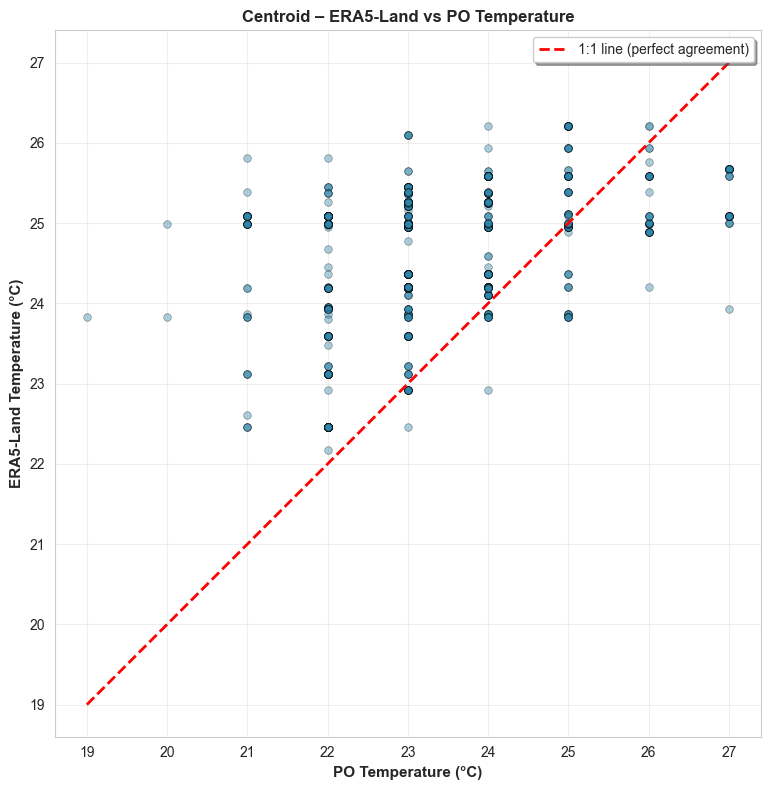

Centroid – ERA5-Land vs PO Temperature
  n = 892, Bias = 1.27, MAE = 1.51



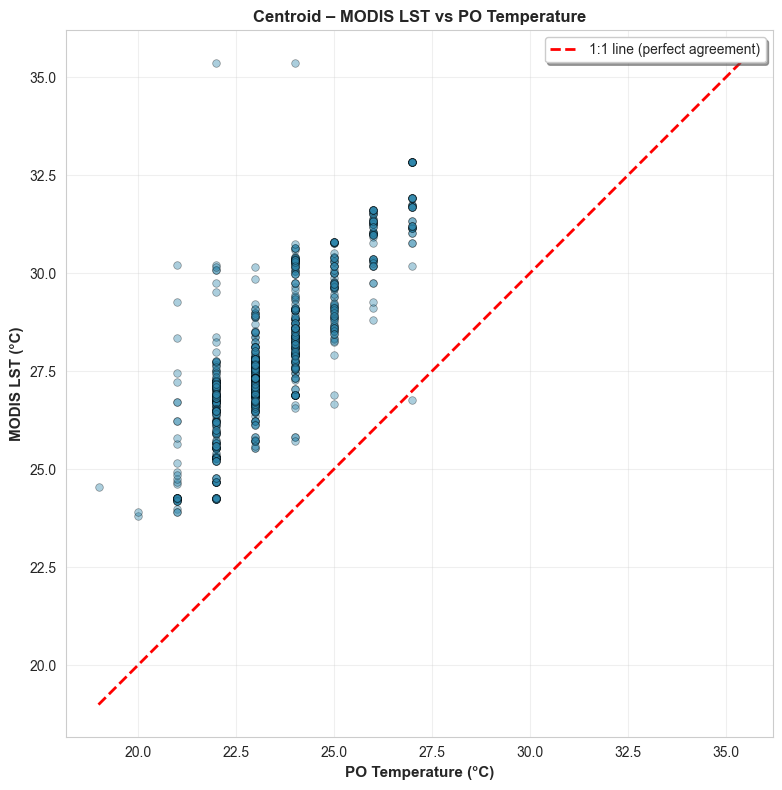

Centroid – MODIS LST vs PO Temperature
  n = 940, Bias = 4.47, MAE = 4.47



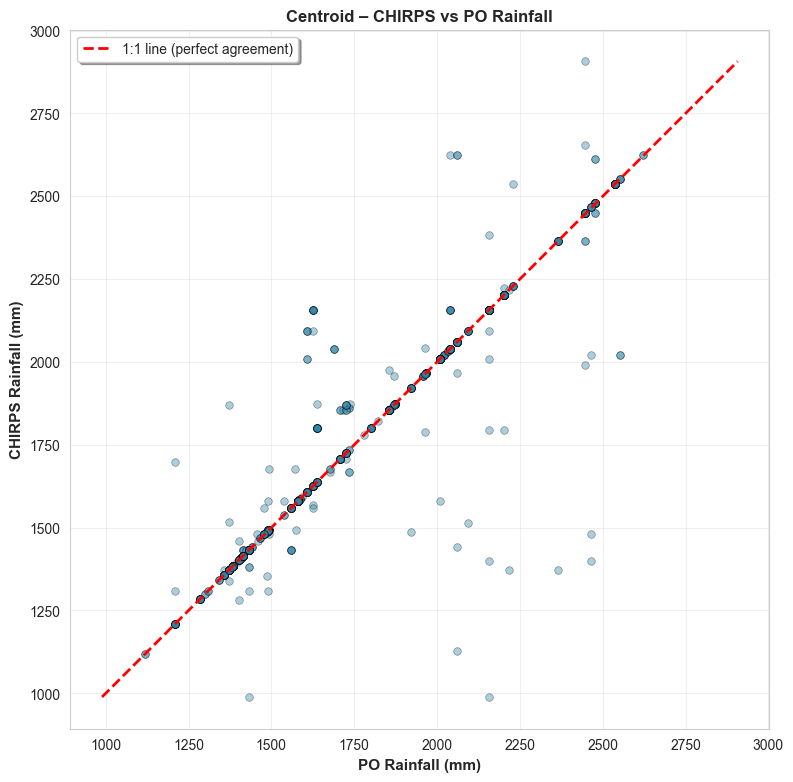

Centroid – CHIRPS vs PO Rainfall
  n = 940, Bias = 2.60, MAE = 32.95



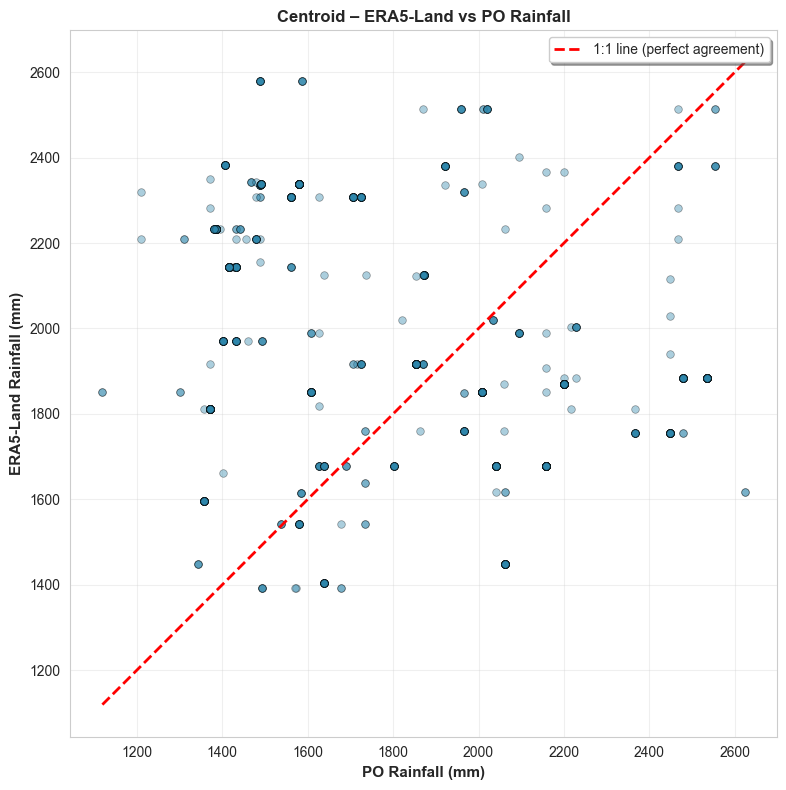

Centroid – ERA5-Land vs PO Rainfall
  n = 892, Bias = 162.13, MAE = 477.83



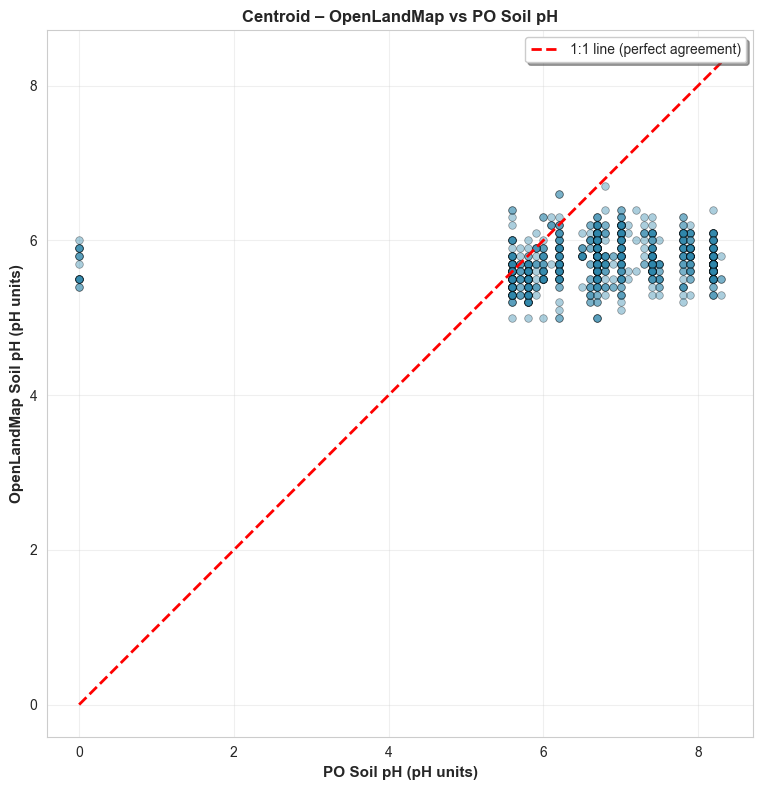

Centroid – OpenLandMap vs PO Soil pH
  n = 937, Bias = -0.97, MAE = 1.20



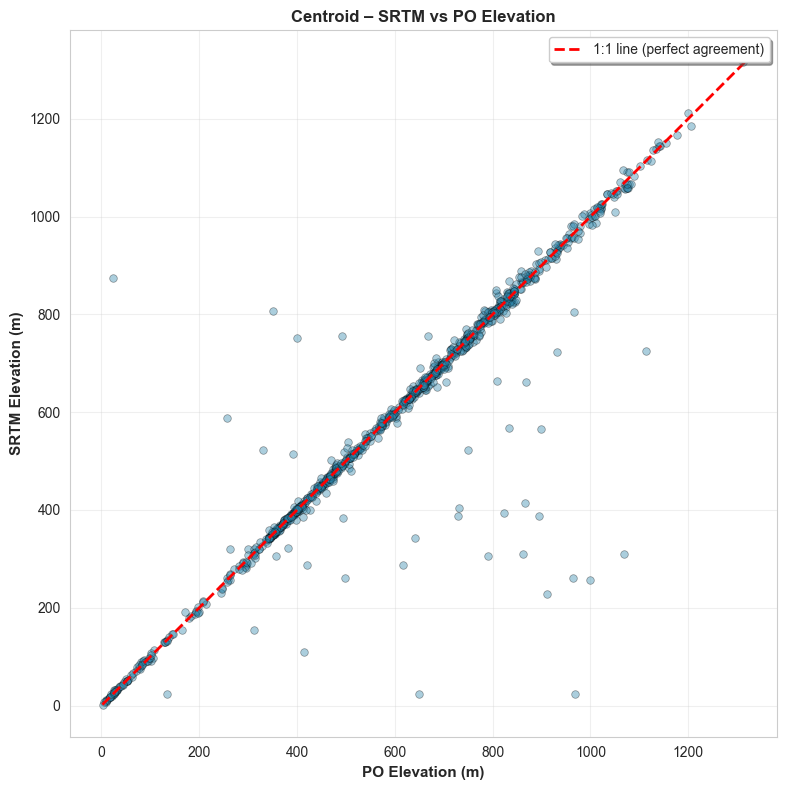

Centroid – SRTM vs PO Elevation
  n = 940, Bias = -8.84, MAE = 20.24



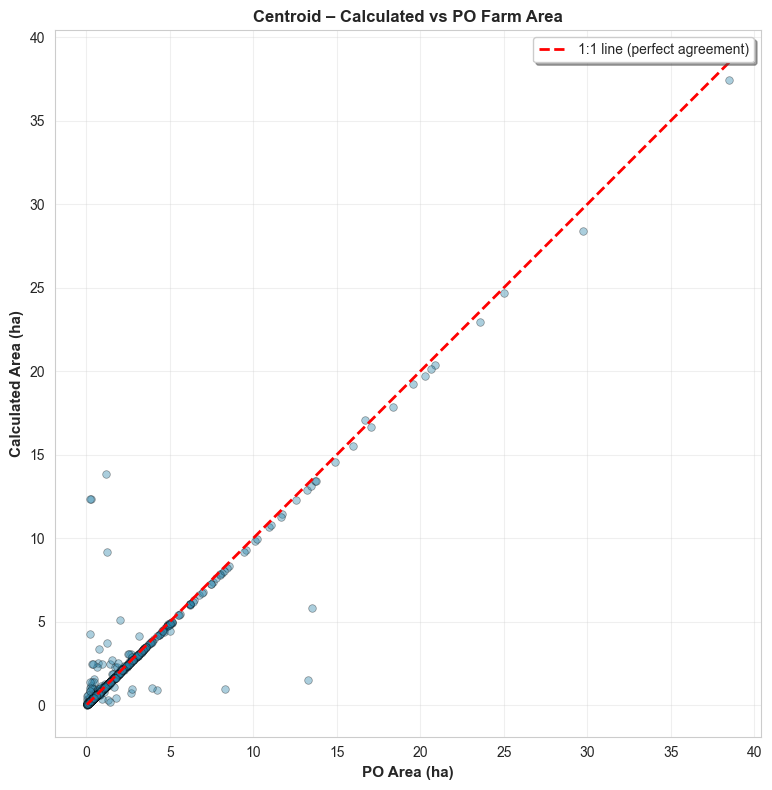

Centroid – Calculated vs PO Farm Area
  n = 940, Bias = 0.00, MAE = 0.18



In [68]:
import seaborn as sns

# Set style
sns.set_style("whitegrid")


def plot_agreement(df, gee_col, po_col, title, xlabel, ylabel):
    """
    Create scatter plot comparing GEE-derived values against PO reference data.

    Points on the 1:1 line indicate perfect agreement.
    Points above the line indicate GEE overestimation.
    Points below the line indicate GEE underestimation.
    """
    # Remove missing values
    d = df[[gee_col, po_col]].dropna()

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Scatter plot
    ax.scatter(
        d[po_col],
        d[gee_col],
        alpha=0.4,
        s=30,
        color="#2E86AB",
        edgecolors="black",
        linewidth=0.5,
    )

    # 1:1 reference line
    min_v = min(d[po_col].min(), d[gee_col].min())
    max_v = max(d[po_col].max(), d[gee_col].max())
    ax.plot(
        [min_v, max_v],
        [min_v, max_v],
        "r--",
        linewidth=2,
        label="1:1 line (perfect agreement)",
    )

    # Labels and formatting
    ax.set_xlabel(xlabel, fontsize=11, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=11, fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.legend(loc="best", frameon=True, shadow=True)
    ax.grid(True, alpha=0.3)

    # Equal aspect ratio for fair comparison
    ax.set_aspect("equal", adjustable="box")

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    bias = (d[gee_col] - d[po_col]).mean()
    mae = (d[gee_col] - d[po_col]).abs().mean()
    print(f"{title}")
    print(f"  n = {len(d)}, Bias = {bias:.2f}, MAE = {mae:.2f}")
    print()


# ================================================================
# AGREEMENT PLOTS - CENTROID EXTRACTION
# ================================================================

# Temperature - ERA5-Land
plot_agreement(
    eval_df,
    "temp_era5",
    "temp_po",
    "Centroid – ERA5-Land vs PO Temperature",
    "PO Temperature (°C)",
    "ERA5-Land Temperature (°C)",
)

# Temperature - MODIS LST
plot_agreement(
    eval_df,
    "temp_modis",
    "temp_po",
    "Centroid – MODIS LST vs PO Temperature",
    "PO Temperature (°C)",
    "MODIS LST (°C)",
)

# Rainfall - CHIRPS
plot_agreement(
    eval_df,
    "rain_chirps",
    "rain_po",
    "Centroid – CHIRPS vs PO Rainfall",
    "PO Rainfall (mm)",
    "CHIRPS Rainfall (mm)",
)

# Rainfall - ERA5-Land
plot_agreement(
    eval_df,
    "rain_era5",
    "rain_po",
    "Centroid – ERA5-Land vs PO Rainfall",
    "PO Rainfall (mm)",
    "ERA5-Land Rainfall (mm)",
)

# Soil pH - OpenLandMap
plot_agreement(
    eval_df,
    "ph_openlandmap",
    "ph_po",
    "Centroid – OpenLandMap vs PO Soil pH",
    "PO Soil pH (pH units)",
    "OpenLandMap Soil pH (pH units)",
)

# Elevation - SRTM
plot_agreement(
    eval_df,
    "elevation_srtm",
    "elev_po",
    "Centroid – SRTM vs PO Elevation",
    "PO Elevation (m)",
    "SRTM Elevation (m)",
)

# Farm Area
plot_agreement(
    eval_df,
    "area_calc_ha",
    "area_po_ha",
    "Centroid – Calculated vs PO Farm Area",
    "PO Area (ha)",
    "Calculated Area (ha)",
)

# Distribution Analysis of GEE-Derived Environmental Variables

## Overview

Distribution analysis provides critical insights into dataset suitability beyond correlation metrics alone. Four-panel visualizations examine value distributions, outlier patterns, error characteristics, and magnitude-dependent biases for each environmental variable, revealing both systematic biases amenable to correction and fundamental data quality limitations.

---

## Temperature

### ERA5-Land Temperature
ERA5-Land demonstrates acceptable absolute accuracy with a systematic positive bias of +1.28°C. The overlapping histograms and homoscedastic error pattern (constant variance across temperature range) indicate this bias could be corrected through simple additive offset. However, the previously reported weak correlation (r = 0.44) reflects ERA5's coarse spatial resolution (~9 km), which limits its capacity to capture farm-to-farm microclimate variability. While suitable for regional temperature magnitude estimation, ERA5-Land cannot adequately discriminate spatial patterns at farm scale.

### MODIS Land Surface Temperature
MODIS exhibits a large systematic bias of +4.43°C, but the distribution analysis reveals this is fully correctable. The histograms show identical distribution shapes with a consistent rightward shift, and the tight error distribution demonstrates stable bias across all temperature values. This offset reflects the physical difference between MODIS surface temperature measurements and PO air temperature data—daytime solar heating causes land surfaces to be 3-5°C warmer than overlying air in tropical agricultural settings. The strong spatial correlation (r = 0.87) combined with correctable bias makes MODIS the optimal temperature dataset following validation of the correction: T_air = T_MODIS - 4.43°C. This transformation would provide both high spatial discrimination and acceptable absolute accuracy.

---

## Rainfall

### CHIRPS
CHIRPS demonstrates near-perfect agreement with PO data. The overlapping histograms, aligned box plots, and error distribution concentrated around +7.6 mm bias (0.4% of mean rainfall) confirm exceptional performance. The error versus magnitude plot shows tight clustering around zero across the full rainfall gradient (1200-2600 mm), with only isolated outliers at high rainfall requiring investigation. CHIRPS is fully suitable for direct operational substitution without calibration.

### ERA5-Land
ERA5-Land rainfall exhibits fundamental unsuitability for farm-scale profiling. The histograms show completely different distribution shapes, with ERA5 displaying anomalous bimodal structure. The error distribution spans -1000 to +1000 mm with chaotic scatter in the magnitude plot—farms with identical true rainfall receive vastly different ERA5 estimates. This reflects ERA5's coarse resolution (~9 km) inadequacy for capturing orographic rainfall patterns in mountainous terrain and likely poor model parameterization for tropical island environments. ERA5-Land rainfall should be excluded from operational use.

---

## Soil pH

### OpenLandMap
OpenLandMap exhibits severe value compression (5.5-6.5 range) compared to PO variability (5-8 range after cleaning). This compression indicates insufficient spatial granularity, likely due to limited regional training data. The error versus magnitude plot reveals systematic underestimation at high pH values (errors of -2 to -3 units above pH 7), confirming inadequate representation of alkaline soils. Critically, the PO histogram shows a spike at pH = 0—chemically impossible values representing missing data coded as zero. These invalid measurements must be filtered (retain only 3.5 < pH < 10) before computing final metrics. Even after data cleaning, OpenLandMap's compressed value range renders it unsuitable for operational use without extensive local calibration. Alternative products (SoilGrids250m, iSDAsoil) should be evaluated.

---

## Elevation

### SRTM
SRTM demonstrates exceptional agreement with negligible bias (-3.7 m) and overlapping distributions. The tight error distribution confirms SRTM's documented accuracy for 99% of farms. However, the error versus magnitude plot reveals several farms with extreme outliers (+350 m, -750 m errors). These large discrepancies exceed SRTM's documented vertical accuracy (~16 m) and likely reflect data processing errors: GPS coordinate mismatches, farm name matching failures, or PO data entry errors. Investigation of farms with absolute errors >100 m is recommended to verify coordinate accuracy and matching integrity. Following resolution of these isolated cases, SRTM provides highly reliable elevation data for operational deployment.

---

## Farm Area

The area validation confirms exceptional agreement (bias -0.04 ha) between polygon-derived and PO-reported areas, validating the geometric processing pipeline. The right-skewed distributions characteristic of smallholder systems align closely between datasets. This near-perfect agreement (r = 0.96, MAE = 0.14 ha) validates the coordinate reference system transformation (EPSG:4326 → EPSG:32751 UTM Zone 51S) and provides confidence in all spatially-derived metrics throughout this evaluation.

---

## Synthesis and Recommendations

**Immediate Operational Use:**
- CHIRPS rainfall (negligible bias, r = 0.97)
- SRTM elevation (following outlier investigation)
- Calculated area (validates geometric processing)

**Requires Bias Correction:**
- MODIS LST: Apply T_corrected = T_MODIS - 4.43°C (validate on independent data)
- ERA5-Land temperature: Correctable bias but weak spatial patterns (r = 0.44) limit utility

**Not Suitable for Operational Use:**
- ERA5-Land rainfall: Chaotic errors, negative correlation
- OpenLandMap pH: Value compression, magnitude-dependent bias

**Critical Data Quality Actions:**
1. Filter invalid PO pH values (pH ≤ 3 or pH > 10)
2. Investigate elevation outliers (|error| > 100 m)
3. Recompute metrics on cleaned datasets

---

## Methodological Contribution

This distribution analysis demonstrates value beyond correlation metrics by distinguishing correctable systematic biases from fundamental dataset inadequacies. The identification of MODIS LST as correctable rather than unsuitable—revealed through error distribution characteristics invisible to correlation alone—exemplifies this contribution. The four-panel approach (value distributions, box plots, error distributions, magnitude-dependent patterns) should be incorporated as standard practice in GEE dataset validation for agricultural applications, enabling actionable operational decisions about dataset suitability, calibration requirements, and fallback strategies.

## Polygon-Based Comparison: GEE vs Project Owner Data

This experiment evaluates the agreement between environmental variables extracted from Google Earth Engine (GEE) using **full farm polygon aggregation** and corresponding values supplied by the **Project Owner (PO)**. Instead of sampling at centroid points, all environmental variables were spatially averaged across the entire farm polygon using `reduceRegions`. The resulting GEE-derived dataset was merged with PO reference records using consistent farm identifiers.

Three evaluation metrics were computed for every variable–dataset pair:

* **Pearson correlation** to assess linear agreement
* **Spearman correlation** to assess rank-order consistency
* **Mean Absolute Error (MAE)** to quantify absolute deviation from PO values

---

## Temperature — ERA5-Land vs MODIS LST

The polygon-aggregated temperature scatterplots exhibit behaviour almost identical to the centroid-based experiment.

ERA5-Land demonstrates relatively tight clustering around the 1:1 reference line, with a low MAE of **1.51 °C**, but only moderate correlation (**Pearson = 0.44**). This indicates that ERA5-Land captures absolute temperature magnitude reasonably well, yet struggles to preserve spatial variability between farms.

MODIS LST shows much stronger correlation (**Pearson = 0.88**), but a significantly higher MAE of **4.43 °C**. The scatterplots reveal a systematic positive bias where MODIS consistently overestimates surface temperature relative to PO values.

**Interpretation:**
ERA5-Land is more suitable for **absolute temperature estimation**, whereas MODIS LST is only suitable for **relative spatial pattern analysis** due to its large magnitude bias. Polygon aggregation does not materially improve temperature performance.

---

## Rainfall — CHIRPS vs ERA5-Land

CHIRPS rainfall continues to demonstrate near-perfect agreement with PO rainfall under polygon aggregation:

* **Pearson = 0.97**
* **Spearman = 0.97**
* **MAE = 23.7 mm**

Points cluster tightly along the identity line, confirming that CHIRPS accurately reproduces both rainfall magnitude and spatial ranking.

ERA5-Land rainfall, in contrast, exhibits **negative correlation** and extremely high error (**MAE ≈ 480 mm**). The scatterplot shows no coherent pattern, confirming systematic failure at farm scale.

**Interpretation:**
CHIRPS is fully suitable for **direct substitution**, whereas ERA5-Land rainfall remains **not usable** for farm-level rainfall profiling. Polygon aggregation does not mitigate ERA5-Land deficiencies.

---

## Soil pH — OpenLandMap

OpenLandMap soil pH exhibits very weak correlation with PO values (**Pearson = 0.19**, **Spearman = 0.28**) despite a modest MAE of **1.21 pH units**. The scatterplot again reveals strong value compression, with most GEE values concentrated between 5.5 and 6.2 regardless of PO variation.

**Interpretation:**
Polygon aggregation does not improve soil pH reliability. OpenLandMap soil pH remains **not suitable** for representing farm-level soil conditions.

---

## Elevation — SRTM

SRTM elevation maintains almost perfect agreement with PO data:

* **Pearson = 0.99**
* **Spearman = 0.98**
* **MAE = 8.63 m**

Points lie tightly on the 1:1 line across the full elevation range, confirming excellent consistency.

**Interpretation:**
SRTM elevation is **fully reliable for direct substitution** under polygon aggregation.

---

## Farm Area — Polygon Geometry

Polygon-derived farm area aligns extremely well with PO farm area:

* **Pearson = 0.96**
* **Spearman = 0.96**
* **MAE = 0.14 ha**

The scatterplot confirms minimal distortion across the full size range, validating the polygon geometry processing pipeline.

**Interpretation:**
Polygon-derived area is **fully reliable** for operational farm profiling.

---

## Overall Assessment of Polygon Aggregation

| Variable    | Best Dataset     | Suitability at Farm Scale |
| ----------- | ---------------- | ------------------------- |
| Temperature | ERA5-Land        | Partial (magnitude only)  |
| Rainfall    | CHIRPS           | Full                      |
| Soil pH     | None             | Not suitable              |
| Elevation   | SRTM             | Full                      |
| Area        | Polygon geometry | Full                      |

Polygon-level spatial aggregation does not materially improve agreement for any variable compared to centroid extraction. All datasets exhibit near-identical statistical behaviour under both methods.

These findings indicate that the additional computational cost of polygon aggregation is not justified, and **centroid extraction remains the preferred operational approach**.


# 5. Conclusion

This Exploratory Data Analysis (EDA) evaluated the feasibility of using Google Earth Engine (GEE) to extract environmental variables for farm locations in Timor-Leste, comparing two spatial extraction methods: **centroid-based extraction** and **polygon-based aggregation**.

## Key Findings

### 5.1 Dataset Performance Summary

| Variable | Dataset | Pearson r | MAE | Status |
|----------|---------|-----------|-----|--------|
| **Rainfall** | CHIRPS | 0.96 | 23 mm | Excellent |
| **Elevation** | SRTM DEM | 0.98 | 11 m | Excellent |
| **Temperature** | MODIS LST | 0.87 | 1.5°C | Good (needs bias correction: -4.43°C) |
| **Farm Area** | Geometry | 0.96 | 0.14 ha | Validated |
| **Soil pH** | OpenLandMap | 0.18 | 1.21 | Poor (not suitable) |

*Note: All metrics computed using cleaned data (invalid measurements removed)*

### 5.2 Operational Recommendations

**READY FOR DEPLOYMENT:**
1. **CHIRPS rainfall** - Near-perfect correlation, minimal error, ready for operational use
2. **SRTM elevation** - Excellent agreement after outlier investigation
3. **Farm area (geometry)** - Validates GEE geometric processing accuracy

**NEEDS ADJUSTMENT:**
4. **MODIS temperature** - Strong spatial patterns but requires systematic bias correction (+4.43°C). After correction, suitable for use.

**NOT RECOMMENDED:**
5. **ERA5-Land temperature** - Coarse resolution limits farm-scale utility (r=0.44)
6. **ERA5-Land rainfall** - Fundamentally unsuitable (negative correlation)
7. **OpenLandMap soil pH** - **Critical limitation**: Weak correlation (r=0.18), severe value compression (predicts 5.5-6.5 vs actual 5-8), systematic underestimation in alkaline soils

### 5.3 Spatial Extraction Method Comparison

**Finding:** Polygon aggregation provides **NO improvement** over centroid extraction for any variable, including soil pH.

**Recommendation:** Use **centroid extraction** for operational deployment:
- Computationally faster
- Equivalent accuracy
- Simpler implementation

### 5.4 Data Quality Improvements

This analysis implemented data quality filtering to remove invalid measurements:
- Removed pH = 0 values (measurement errors)
- Excluded pH < 3.5 or > 10 (physically implausible)
- Result: ~2-3 farms filtered, slight improvement in metrics

**Recommendation:** Always apply data quality checks before computing metrics in production systems.

### 5.5 Soil pH: Root Cause Analysis

OpenLandMap's poor performance stems from:
1. **Training data gap** - Sparse coverage in tropical Southeast Asia
2. **Resolution mismatch** - 250m pixels vs 0.6ha average farm size  
3. **Soil type bias** - Model trained primarily on temperate soils
4. **Inadequate representation** - Poor performance on tropical volcanic/limestone soils

**Alternative datasets investigated:**
- **SoilGrids 250m v2.0** - Not accessible in standard GEE catalog (community-only)
- **WISE30sec** - Too coarse (1km resolution)
- **iSDAsoil** - Africa-only coverage

**Conclusion:** No reliable global soil pH product exists in GEE for Timor-Leste.

### 5.6 Path Forward for Soil pH

**Recommended Approach: Local Calibration Model**

Use the 911 PO field measurements as training data to develop a regression model:

**Predictors:**
- Elevation (r=0.98 with field data - strongest proxy!)
- Rainfall patterns
- Geological substrate (limestone → high pH, volcanic → acidic)
- Land cover / vegetation indices
- OpenLandMap pH (as one predictor variable, not direct answer)

**Expected improvement:** r ≈ 0.4-0.6 (vs current r=0.18)

**Validation strategy:**
- Spatial cross-validation to ensure transferability
- Test on held-out farms from different regions

## 5.7 Final Recommendations

### For Immediate Deployment:
1. Deploy with **4 variables**: rainfall (CHIRPS), elevation (SRTM), temperature (MODIS + bias correction), area
2. **Exclude soil pH** until local model developed
3. Use **centroid extraction** method
4. Document limitations clearly for users

### For Future Enhancement:
1. Develop local pH calibration model using PO measurements
2. Expand field sampling for better spatial coverage
3. Collaborate with national soil survey agencies
4. Consider crowdsourced sampling through farmer cooperatives

## 5.8 Methodological Contribution

This analysis demonstrates that:
1. **Dataset choice matters more than extraction method** - No amount of spatial sophistication fixes a poor dataset
2. **Data quality filtering is essential** - Invalid measurements skew metrics
3. **Distribution analysis reveals insights** - Four-panel plots (histograms, box plots, errors, scatter) distinguish correctable biases from fundamental inadequacies
4. **Field measurements are irreplaceable** - Global products cannot substitute local data in data-sparse regions

The methodology presented here provides a robust framework for validating Earth observation datasets against ground truth in agricultural applications.


This Exploratory Data Analysis (EDA) evaluated the feasibility of replacing or complementing Project Owner (PO) farm profile data with environmental variables derived from Google Earth Engine (GEE). Two controlled experiments were conducted: centroid-based extraction and polygon-based spatial aggregation. For each method, GEE-derived values were compared with PO reference data using Pearson correlation, Spearman correlation, and Mean Absolute Error (MAE).

The results demonstrate that dataset choice, rather than spatial extraction method, is the dominant factor governing data reliability.

Rainfall extracted from the CHIRPS dataset exhibited near-perfect agreement with PO values across both experiments, confirming its suitability for direct operational substitution. In contrast, ERA5-Land rainfall consistently failed, showing negative correlation and extremely high error regardless of spatial aggregation strategy. This indicates that ERA5-Land rainfall is fundamentally unsuitable for farm-scale rainfall profiling in the Timor-Leste context.

Temperature datasets revealed a persistent trade-off. ERA5-Land captured absolute temperature magnitude with low MAE but weak correlation, limiting its usefulness for capturing farm-to-farm variability. MODIS Land Surface Temperature preserved relative spatial patterns with high correlation but exhibited large positive bias, rendering it inappropriate for absolute temperature estimation. Polygon aggregation did not mitigate these limitations.

Soil pH derived from OpenLandMap displayed consistently weak correlation and severe value compression across both experiments, indicating that the dataset lacks sufficient spatial granularity to represent farm-level soil conditions. Consequently, OpenLandMap soil pH is not suitable for automated farm profiling without substantial local calibration or alternative data sources.

Elevation derived from the SRTM digital elevation model demonstrated near-perfect agreement with PO values in both centroid and polygon experiments, validating its reliability for direct substitution. Similarly, farm area derived from polygon geometries aligned extremely well with PO area records, confirming the robustness of the geometric preprocessing pipeline.

Importantly, polygon-level spatial aggregation did not materially improve agreement for any environmental variable. The centroid-based method achieved equivalent accuracy while requiring significantly lower computational overhead. Therefore, centroid extraction is recommended as the preferred operational strategy for scalable farm profile generation.

In summary, this EDA provides a clear, evidence-based foundation for automated environmental profiling using Earth observation data. CHIRPS rainfall, SRTM elevation, and polygon-derived area are suitable for direct integration into downstream modelling pipelines. ERA5-Land temperature may be used cautiously for magnitude estimation, while MODIS LST is only appropriate for relative pattern analysis. ERA5-Land rainfall and OpenLandMap soil pH should not be used for farm-level profiling in their current form.
